# plot eigen values

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy.stats import genextreme 
from scipy.optimize import minimize
from collections import Counter
import pandas as pd
#!pip3 install skextremes
#import skextremes as ske
from scipy.optimize import curve_fit
from scipy.stats import invweibull, exponweib
from sklearn.preprocessing import MinMaxScaler
import gc
from scipy.stats import gumbel_r
from sklearn.neighbors import KernelDensity
from matplotlib import rcParams
rcParams['text.usetex'] = True
from scipy.stats import kurtosis
from netCDF4 import Dataset as NetCDFFile

In [2]:
# function for the histogram calculation after Saberi et al. 
def filter(ar):
    return ar[np.isfinite(ar)]    
def histo_saberi(X, nbins = 23):
    x = np.log(X)
    x = filter(x) # remove the inf nan 
    xmin = np.min(x)
    xmax = np.max(x)
    dx = (xmax - xmin) / nbins
    print(dx)
    xbox = np.zeros(nbins)
    nbox = np.zeros(nbins)
    for i in range(0,len(x)):
        
        b = int((x[i] - xmin) / dx)
        #print(b)
        if (b==nbins):
            b -= 1
        nbox[b] += 1
        xbox[b] += x[i]
    ndata = np.sum(nbox)
    xbin = []
    ybin = []
    bin_size = []
    for i in range(0,nbins):
        xbin.append(np.exp(xbox[i] / nbox[i]))
        bin_size.append(np.exp(xmin) * (np.exp((i + 1) * dx) - np.exp(i * dx)))
        ybin.append(nbox[i] / (ndata * bin_size[i]))
    return xbin,bin_size,ybin
    
def histo_saberi_nolog(X, nbins = 23):
    #x = np.log(X)
    #x = filter(X) # remove the inf nan 
    x = X.copy()
    xmin = np.min(x)
    xmax = np.max(x)
    dx = (xmax - xmin) / nbins
    print(dx)
    xbox = np.zeros(nbins)
    nbox = np.zeros(nbins)
    for i in range(0,len(x)):
        
        b = int((x[i] - xmin) / dx)
        #print(b)
        if (b==nbins):
            b -= 1
        nbox[b] += 1
        xbox[b] += x[i]
    ndata = np.sum(nbox)
    xbin = []
    ybin = []
    bin_size = []
    for i in range(0,nbins):
        xbin.append(xbox[i] / nbox[i])
        bin_size.append(dx)
        ybin.append(nbox[i] / (ndata * bin_size[i])) # density = True
    return xbin,bin_size,ybin

from scipy.stats import genextreme as gev
def main(rvs):
    shape, loc, scale = gev.fit(rvs)
    return shape, loc, scale
# define the true objective function
def objective(x, loc, sigma):
    c = 1/0.46
    return invweibull.pdf(x, c,loc,sigma)
    #return exponweib.pdf(x, c,loc,sigma)
def objective2(x, loc, sigma):
    c = 1.46
    y = (x -loc) /sigma
       
    return c*(y**(-c-1))*np.exp(-y**(-c))
    #return exponweib.pdf(x, c,loc,sigma)
def fun(params,tides):
    F = lambda x: genextreme.pdf(x,*params)
    result = -sum([np.log(d) for d in np.diff([0]+[F(_) for _ in tides]+[1])])
    return result


In [3]:
def plot_all_lambdas(header,data_dir,length , logi, time ,lambdas, extra, year1, year2, color):
    

    plt.figure(figsize=(9, 9))  
      
    # Remove the plot frame lines. They are unnecessary chartjunk.  
    ax = plt.subplot(111)  
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)  
      
    # Ensure that the axis ticks only show up on the bottom and left of the plot.  
    # Ticks on the right and top of the plot are generally unnecessary chartjunk.  
    ax.get_xaxis().tick_bottom()  
    ax.get_yaxis().tick_left()  
    colors= ['k','b','g','c']
    k = 0
    df_all = []
    for year in range(year1,year2):
        print(year)
        df = np.loadtxt(data_dir+"eigenvalue_"+str(year)+extra+"_merged.txt") #load the data of eigenvalues for a decade!
        df_all.extend(df)
        #print(df_all[0:100])
        del df 
        gc.collect()
        k +=1 
    df = pd.DataFrame() 
    df['eigenvalue']     = df_all
    # saving the dataframe 
    df.to_csv(data_dir+'/All_eigenvals_1979_2020_3_hourly_'+extra+'.csv')     
    #xbin,bin_size,ybin = histo_saberi(df_all, nbins = 60)
    ##xbin,bin_size,ybin = histo_saberi_nolog(df_all, nbins = 23)
    #plt.loglog(xbin,ybin,'-o',color=color,alpha=1,markerfacecolor='none')
    ##plt.plot(xbin,ybin,'-o',color=colors[0],alpha=1,markerfacecolor='none')
    ##plt.loglog(np.linspace(10e-5,10e5),(np.linspace(10e-5,10e5)**-1.4)/10,'r--')
    ## fit on loglog 
    #a = np.asarray(xbin[-3:])
    #z = a
    #b = np.asarray(ybin[-3:])
    #logA = np.log(z)
    #logB = np.log(b)
    ##m,c = np.polyfit(logA, logB, 1)
    ##y_fit = np.exp(m*logA + c) # calculate the fitted values of y 
   ## plt.loglog(z, y_fit, 'c--')
    #
    #
    ##plt.text(10e-13,10e4,str(m),fontsize=20, color='c')
    #a = np.asarray(xbin[-38:-4])
    #z = a
    #b = np.asarray(ybin[-38:-4])
    #logA = np.log(z)
    #logB = np.log(b)
    ##m,c = np.polyfit(logA, logB, 1)
    ##y_fit = np.exp(m*logA + c) # calculate the fitted values of y 
    ##plt.loglog(z, y_fit, 'b--')
    ##plt.text(10e-12,10e9,str(m),fontsize=20, color='b')
    #
    #
    #
    #plt.xlabel(r'$\lambda$',fontsize=20)
    #plt.ylabel(r'$PDF$',fontsize=20)
    #plt.ylim([10e-6,10e14])
    #plt.xlim([10e-20,10e2])
    #plt.savefig(header+lambdas+"_"+time+"_"+logi+"_"+length+extra+".png", bbox_inches = 'tight',
    #            pad_inches = 0,dpi=300, transparent=True)


In [4]:
def plot_N_largest_eigenvalue(header,length,logi,time,N,year1, year2, color):
        
    lambdas = str(N)+"_largest"
    colors= ['k','b','g','c']
    k = 0
    df_all = []
    #for year in [1979,1989,1999,2009]:
    #for year in [1979,1989,1999,2009]:    
    for year in range(year1,year2):
        print(year)
        #df = np.loadtxt("eigenvalues_2L/eigenvalue_"+str(year)+"_"+str(year+11)+"_merged_"+str(N)+"_largest_2L.txt") #load the data of eigenvalues for a decade!
        df = np.loadtxt(data_dir+"eigenvalue_"+str(year)+"_"+extra+"_merged_L"+str(N)+".txt") #load the data of eigenvalues for a decade!
        df_all.extend(df)
        del df 
        gc.collect()
        k +=1 
    df_all.sort()
    df = np.array(df_all).reshape(-1, 1)
    dff = pd.DataFrame() 
    dff['eigenvalue']     = df_all
    # saving the dataframe 
    dff.to_csv('L_'+str(N)+'_eigenvals_'+header+lambdas+"_"+time+"_"+logi+"_"+length+extra+'.csv')     
    #def func_GEV(x,sigma,miu):
    #    etta=1/5
    #    t = (1 + (((x -miu)/sigma)*etta ))**(-1/etta)
    #    f = (1 / sigma )*((t**(etta+1)) * np.exp(-t))
    #    return f
    #def func_GEV_1(x,alpha,s,m):
    #    #m=-2
    #    #alpha=1
    #    #s=1
    #    t = ((x-m)/s)**(-alpha)
    #    tt = ((x-m)/s)**(-1-alpha)
    #    f = np.exp(-t)
    #    f = f*tt*(alpha/s)
    #    return f
    ## instantiate and fit the KDE model
    plt.figure(figsize=(12, 9)) 
    #kde = KernelDensity(bandwidth=5, kernel='gaussian')
    #stt =.001
    #e = 700
    #dd = 100
    #kde.fit(df)
    #x_d = np.linspace(stt,e,dd).reshape(-1, 1)
    ## score_samples returns the log of the probability density
    #logprob = kde.score_samples(x_d)
    xbin,bin_size,ybin = histo_saberi_nolog(df_all, nbins = 200)
    #plt.hist(df,bins=50,alpha=.5, color='Grey',density=True,label='histogram')
    #plt.plot(x_d, np.exp(logprob), alpha=1,label="KDE fit")
    ybin = np.array(ybin)
    xbin = np.array(xbin)
    ybin = ybin[~np.isnan(xbin)]
    xbin = xbin[~np.isnan(xbin)]
    plt.plot(xbin,ybin,'o',color=color,markerfacecolor='none')
    #popt, _ = curve_fit(func_GEV_1, xbin,ybin ,maxfev = 6000000)
    #a,b,c = popt
    ## use optimal parameters to calculate new values
    ##y_new = func_GEV( np.linspace(s,e,dd), a, b)
    #y_new = func_GEV_1( np.linspace(stt,e,dd), a, b,c)
    ##plt.plot(x_d,y_new,'k--', alpha=0.5,label=r"Frechet fit shape= $\frac{1}{5}$")
    ##plt.plot(x_d,y_new,'k--', alpha=0.5,label=r"Frechet fit "+"\n"+r"$\alpha$ ="+str(a)+"\n"+" s = "+str(b)+"\n"+" m = "+str(c))
    #plt.legend(fontsize=20)
    fig = plt.gcf()
    fig.set_size_inches(12.5, 8.5)
    fig.savefig(header+str(N)+"_"+extra+'_new.png', dpi=300, bbox_inches = 'tight',  pad_inches = 0, transparent=True)


Level 70 is being processed!
(0.8787878787878789, 0.0, 0.0, 1.0)
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020


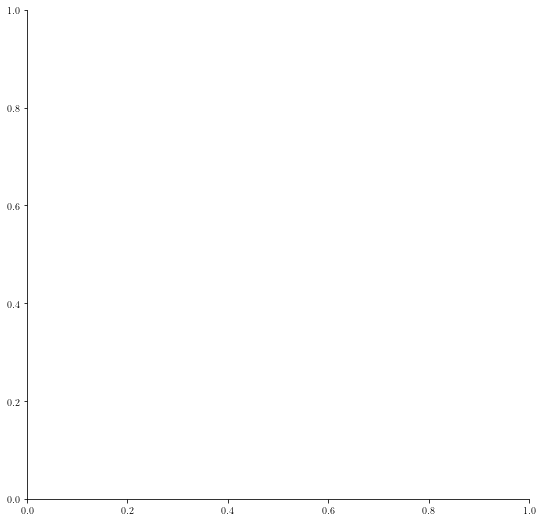

In [5]:
#data_dir = "/p/projects/gvca/bijan/ERA5_percolation/zonal/060_750/"
i=1
#for level in ['70','300','400','500','600','700','750','800','850','950','1000']:
for level in ['70']:    
    print('Level '+level+' is being processed!')
    data_dir="/media/fallah/bijan/ABBAS/final_eigen_values/060_"+level+"/"
    length = "L"
    logi   = "loglog"
    time   = "all_years"
    lambdas = "all_lambdas"
    extra= '_060_'+level
    year1 = 1979
    year2 = 2021
    header = "hourly_original_"
    N=13
    
    
    cmap = plt.get_cmap('jet_r',N)
    color=cmap(i)
    print(color)
    plot_all_lambdas(header,data_dir,length , logi, time ,lambdas, extra, year1, year2, color)
    i+=1

## Plot for L1,2,3 : 

(0.7673796791443851, 0.0, 0.0, 1.0)
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
3.264281770520828e-05


<ipython-input-2-b05bcd935c9e>:54: RuntimeWarning: invalid value encountered in double_scalars
  xbin.append(xbox[i] / nbox[i])


(0.7673796791443851, 0.0, 0.0, 1.0)
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
1.981540619470993e-05


<ipython-input-2-b05bcd935c9e>:54: RuntimeWarning: invalid value encountered in double_scalars
  xbin.append(xbox[i] / nbox[i])


(0.7673796791443851, 0.0, 0.0, 1.0)
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
5.902285169483868e-06


<ipython-input-2-b05bcd935c9e>:54: RuntimeWarning: invalid value encountered in double_scalars
  xbin.append(xbox[i] / nbox[i])


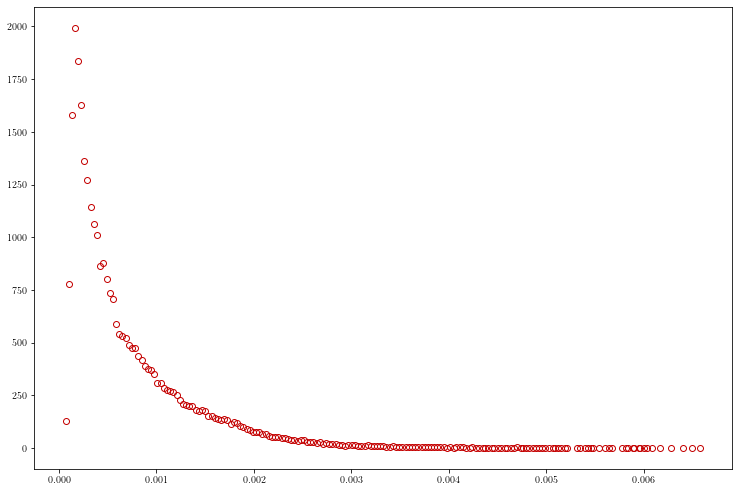

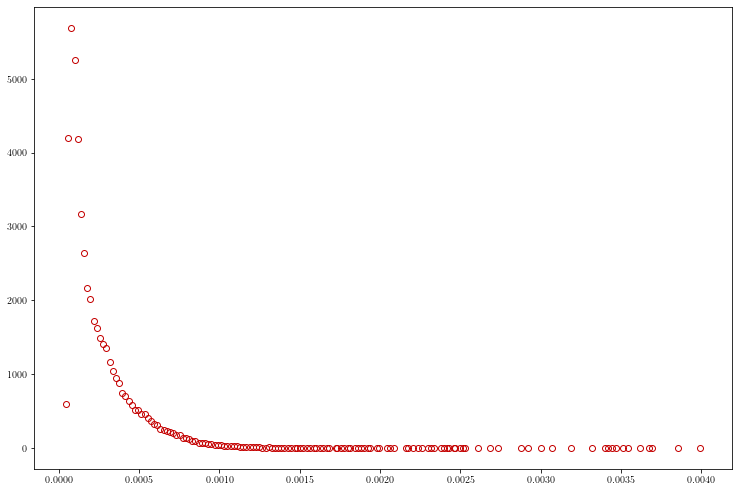

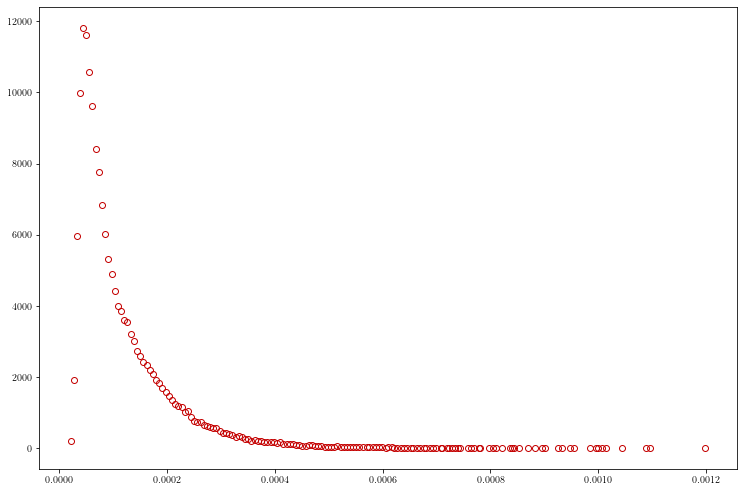

In [9]:
#data_dir = "/p/projects/gvca/bijan/ERA5_percolation/zonal/060_750/"
for N in range(1,4):
    
    i=1
    #for level in ['2','5','10','70','150','200','300','400','500','600','700','750','800', '850','900','950','1000']:
    for level in ['30']: 
        data_dir="/media/fallah/bijan/ABBAS/final_eigen_values/060_"+level+"/"
        length = "L"
        logi   = "nologlog"
        time   = "all_years"
        extra= '060_'+level
        year1 = 1979
        year2 = 2021
        header = "hourly_zonal_"
        
        NN = 18
        cmap = plt.get_cmap('jet_r',NN)
        color=cmap(i)
        print(color)
        #plot_all_lambdas(header,data_dir,length , logi, time ,lambdas, extra, year1, year2, color)
        plot_N_largest_eigenvalue(header,length,logi,time,N,year1, year2, color=color)
        i+=1

## Plot from the merged CSV for each Level 

0.6969337815126377


KeyboardInterrupt: 

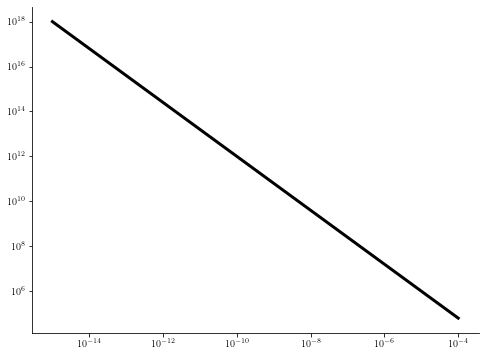

In [8]:
# All eigenvalues:
#for level in ['70','150','200','300','400','500','600','700','750','800', '850','900']:
plt.figure(figsize=(8, 6))  
# Remove the plot frame lines. They are unnecessary chartjunk.  
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
# Ensure that the axis ticks only show up on the bottom and left of the plot.  
# Ticks on the right and top of the plot are generally unnecessary chartjunk.  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  
NN = 18
cmap = plt.get_cmap('gist_rainbow',NN)
ax.loglog(np.linspace(10e-16,10e-5),(np.linspace(10e-16,10e-5)**-1.2),'k-',linewidth=3.0,alpha=1)
#ax.loglog(np.linspace(10e-16,10e-5),(np.linspace(10e-16,10e-5)**-1.1)/10,'k-',linewidth=3.0 , label="-1.1",alpha=.7)
#ax.loglog(np.linspace(10e-16,10e-5),(np.linspace(10e-16,10e-5)**-1.0),'k-',linewidth=3.0 , label="-1.0",alpha=.5)
#ax.loglog(np.linspace(10e-16,10e-5),(np.linspace(10e-16,10e-5)**-.9)*10,'k-',linewidth=3.0 , label="-0.9",alpha=.3)
#for level in ['500']:
i = 0
for level in ['2','5','10','30','70','150','200','300','400','500','600','700','750','800', '850','900','950','1000']:
    file="All_eigenvals_hourly_original_all_lambdas_all_years_loglog_L_060_"+level+".csv"
    ff  = pd.read_csv(file, index_col=False)
    color=cmap(i)
    xbin,bin_size,ybin = histo_saberi(ff['eigenvalue'].values[0:-1:1], nbins = 51)
    ax.loglog(xbin,ybin,'-o',linewidth=1.0,color=color,markerfacecolor='none', alpha=.6, label=level)
    # fit on loglog 
    #a = np.asarray(xbin[14:-2])
    #z = a
    #b = np.asarray(ybin[14:-2])
    #logA = np.log(z)
    #logB = np.log(b)
    #m,c = np.polyfit(logA, logB, 1)
    #y_fit = np.exp(m*logA + c) # calculate the fitted values of y 
    #color=cmap(i)
    #plt.loglog(z, y_fit, '-',color=color,linewidth=3.0)
    #plt.text(z[-1]*100,y_fit[-1]*100,str(np.round(m,2)),fontsize=20, color=color)
    i+=1
    print("level "+level+" is finished!")
plt.xlabel(r'$\lambda$',fontsize=20)
plt.ylabel(r'$PDF$',fontsize=20)
ax.legend(fontsize=20, bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)
plt.savefig("ALL_EIGENVALUES_LEVELS.png", bbox_inches = 'tight',  pad_inches = 0,dpi=300, transparent=True)
    
    

## plot the LN 

In [ ]:
from scipy import stats

# All eigenvalues:
#for level in ['70','150','200','300','400','500','600','700','750','800', '850','900']:
plt.figure(figsize=(8, 6))  
# Remove the plot frame lines. They are unnecessary chartjunk.  
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
# Ensure that the axis ticks only show up on the bottom and left of the plot.  
# Ticks on the right and top of the plot are generally unnecessary chartjunk.  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  
NN = 13
N=1
cmap = plt.get_cmap('gist_rainbow',NN)

#ax.loglog(np.linspace(10e-16,10e-5),(np.linspace(10e-16,10e-5)**-1.1)/10,'k-',linewidth=3.0 , label="-1.1",alpha=.7)
#ax.loglog(np.linspace(10e-16,10e-5),(np.linspace(10e-16,10e-5)**-1.0),'k-',linewidth=3.0 , label="-1.0",alpha=.5)
#ax.loglog(np.linspace(10e-16,10e-5),(np.linspace(10e-16,10e-5)**-.9)*10,'k-',linewidth=3.0 , label="-0.9",alpha=.3)
#for level in ['500']:
i = 0
for level in ['70','150','200','300','400','500','600','700','750','800', '850','900','950']:
    
    color=cmap(i)
    file = "L_"+str(N)+"_eigenvals_hourly_zonal_"+str(N)+"_largest_all_years_nologlog_L060_"+level+".csv"
    ff  = pd.read_csv(file, index_col=False)
    df = np.array(ff).reshape(-1, 1)
    xbin,bin_size,ybin = histo_saberi_nolog(df, nbins = 21)
    ybin = np.array(ybin)
    xbin = np.array(xbin)
    ybin = ybin[~np.isnan(xbin)]
    xbin = xbin[~np.isnan(xbin)]
    plt.plot(xbin,ybin,'o-',color=color,markerfacecolor='none')
    plt.savefig("L_"+str(N)+"_"+level+"_EIGENVALUES_LEVELS.png", bbox_inches = 'tight',  pad_inches = 0,dpi=300, transparent=True)
    i+=1

In [ ]:
from scipy.stats import genextreme as gev
import matplotlib.pyplot as plt
import numpy as np
#fig, ax = plt.subplots(1, 1)

x=xbin
diff = 100000
difi = 0
shapi = 0
loci=0
scali=0
# The order for this is array, shape, loc, scale
for shape in np.linspace(-.1,-1.3,50):
    for loc in  range(10000,20000,100):
        for scale in range(1000,5000,100):
            F=gev.pdf(x,shape,loc=loc,scale=scale)
            difi = np.sqrt(np.sum((F-ybin)**2))
            if difi < diff :
                diff = difi
                shapi = shape
                scali = scale
                loci = loc
                
                
print(scali, loci, shapi)

In [ ]:
N=1
level="500"
color="k"
file = "L_"+str(N)+"_eigenvals_hourly_zonal_"+str(N)+"_largest_all_years_nologlog_L060_"+level+".csv"
ff  = pd.read_csv(file, index_col=False)
dff = np.array(ff['eigenvalue'].values).reshape(-1, 1)
xbin,bin_size,ybin = histo_saberi_nolog(dff, nbins = 1000)
#xbin,bin_size,ybin = histo_saberi_nolog(df_all, nbins = 200)
ybin = np.array(ybin)
xbin = np.array(xbin)
ybin = ybin[~np.isnan(xbin)]
xbin = xbin[~np.isnan(xbin)]
x=xbin
# The order for this is array, shape, loc, scale
F=gev.pdf(x,shape,loc=loci,scale=scali)

plt.plot(x,F,'g',lw=2)

plt.plot(xbin[:],ybin[:],'o-',color=color,markerfacecolor='none', alpha=.6)
plt.show()


In [ ]:
# Violin Plots : 

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

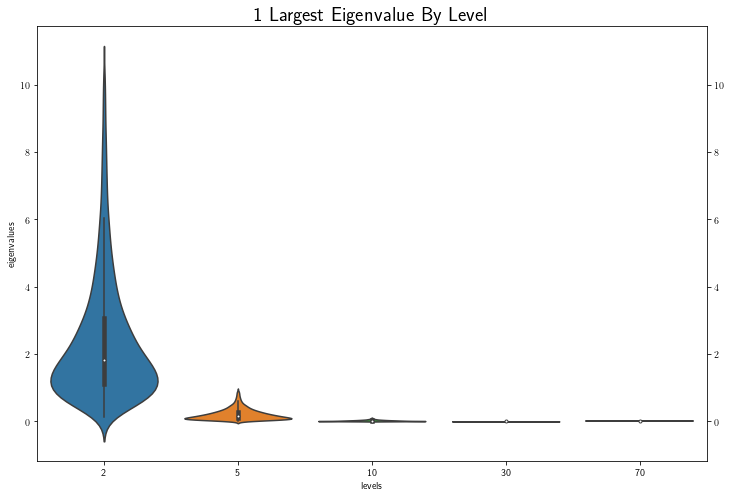

In [21]:
i = 0
data_fame=pd.DataFrame()
N=1
eigenvals = []
levels = []
#for level in ['150','200','300','400','500','600','700','750','800','850','900','950','1000']:
for level in ['2','5','10','30','70']:
    
    file = "L_"+str(N)+"_eigenvals_hourly_zonal_"+str(N)+"_largest_all_years_nologlog_L060_"+level+".csv"
    ff  = pd.read_csv(file, index_col=False)
    df = ff['eigenvalue']
    df = df[df<np.percentile(df,99)]
    eigenvals.extend(df)
    levels.extend([level]*len(df))
    
    i+=1
data_fame['levels'] = levels
data_fame['eigenvalues'] =eigenvals
plt.figure(figsize=(12, 8))  
ax = plt.subplot(111)  
sns.violinplot(x="levels",y="eigenvalues",  data=data_fame, bw = 0.2, scale="width")
ax.tick_params(right=True, top=False, labelright=True, labeltop=False,rotation=0)
ax.set_title(str(N)+" Largest Eigenvalue By Level", fontsize=20)
plt.savefig("Violin_plot_L_"+str(N)+"_smalls.png", bbox_inches = 'tight',  pad_inches = 0,dpi=300, transparent=True)

## t-student sampling 

## time evolution 

In [ ]:
from datetime import date, timedelta
from datetime import datetime
sdate = date(1979,1,1)
edate = date(2021,1,1)
dates = pd.date_range(sdate,edate,freq='h')
dates.shape 

In [105]:
data_final = np.zeros((18,119879))
N=2848
k = 0
#
#'150','200','900'
for level in ["2",'5','10','30','70','300','400','500','600','700','800','850','750','950','1000']:
    file = "All_eigenvals_hourly_original_all_lambdas_all_years_loglog_L_060_"+level+".csv"
    ff  = pd.read_csv(file, index_col=False)
    data =ff['eigenvalue'].values[639::640]
    data_ma = np.convolve(data, np.ones(N)/N, mode='full')
    data_final[k,:] = data_ma[N:-N]
    k+=1
    print(level)
    del ff, data, data_ma
    
    

ValueError: could not broadcast input array from shape (122486) into shape (119879)

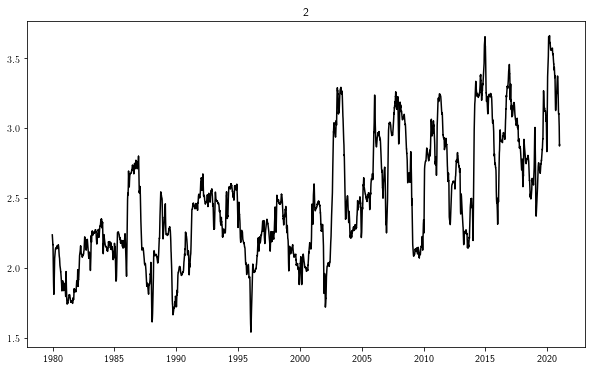

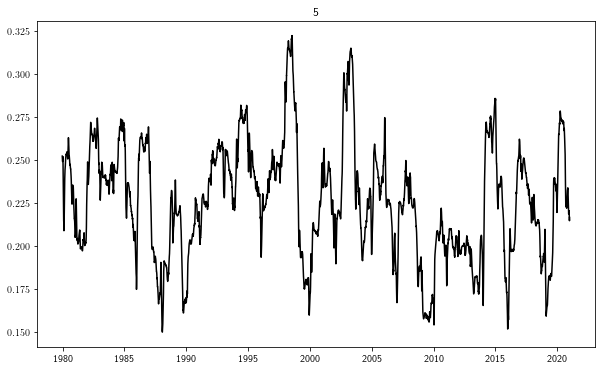

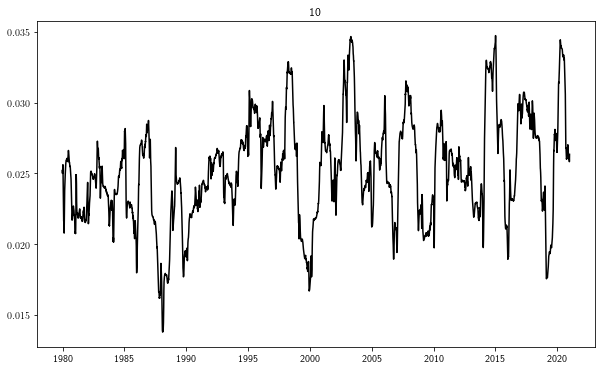

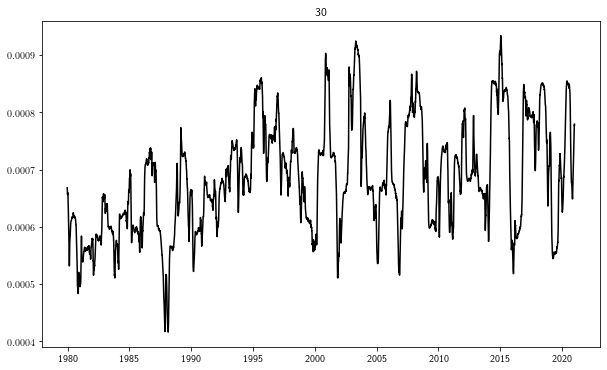

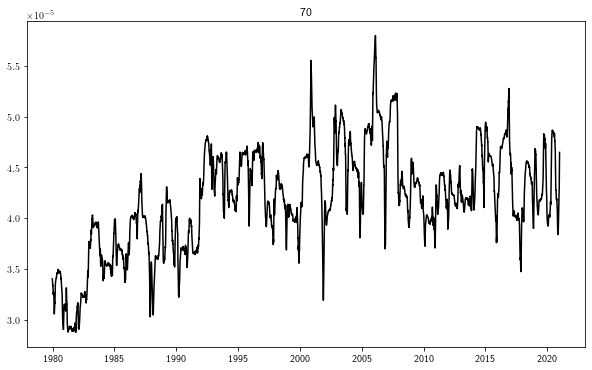

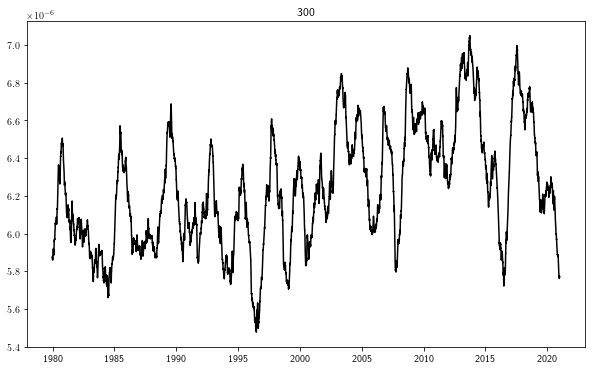

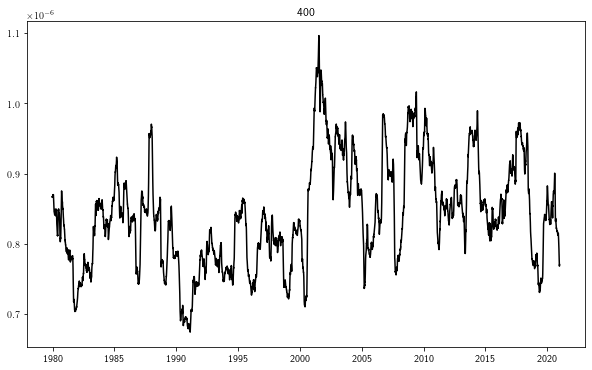

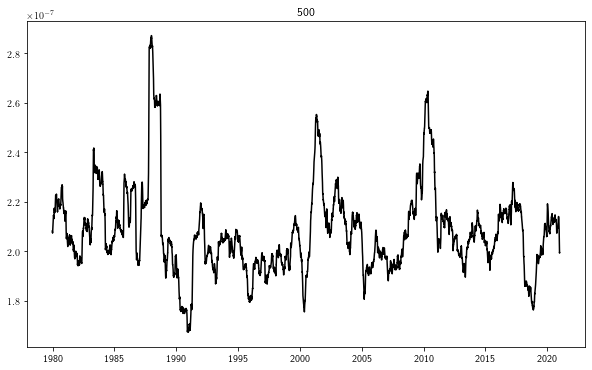

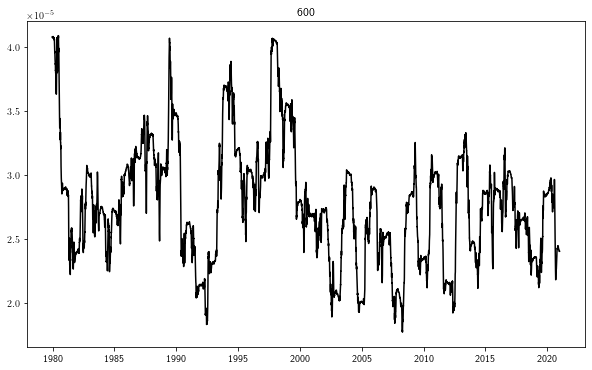

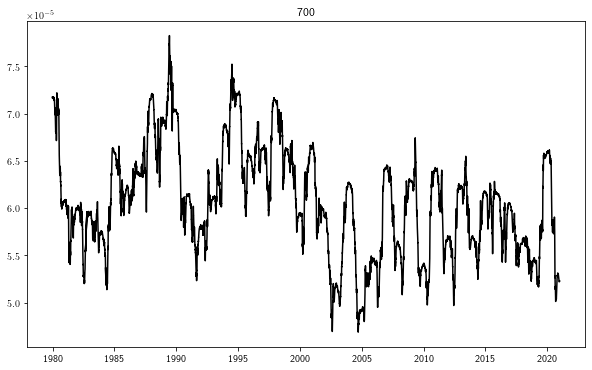

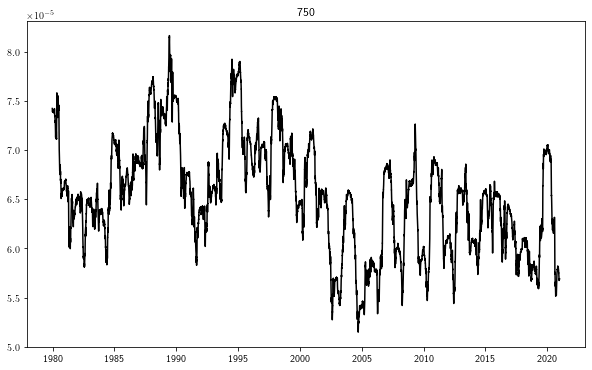

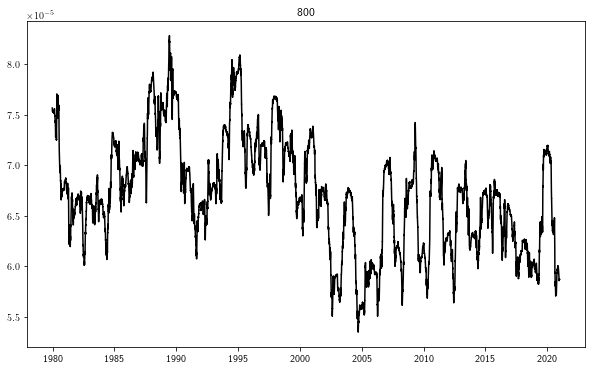

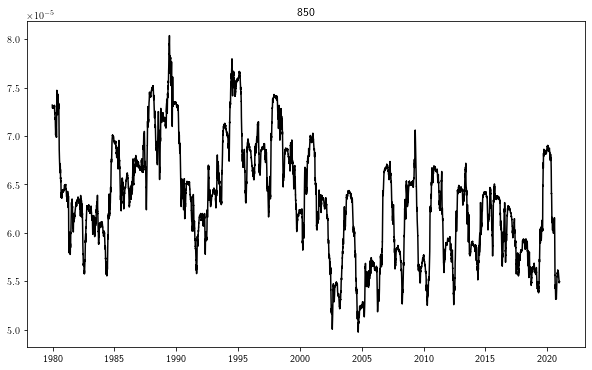

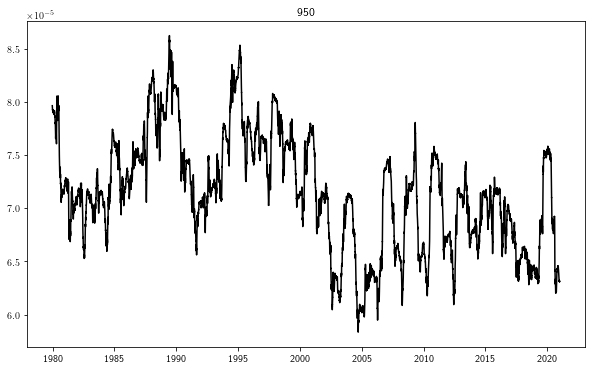

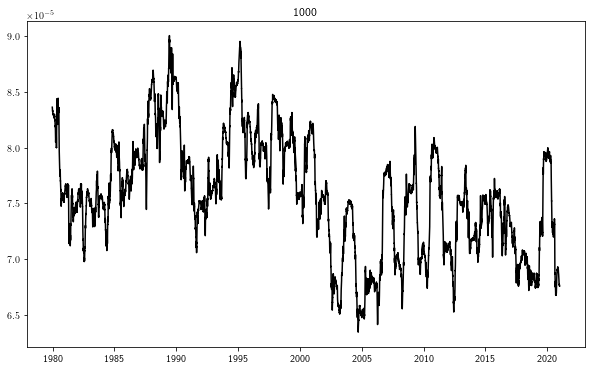

In [103]:
plt.rcParams.update({'figure.figsize': (10,6)})

#def normalized(timeseries):
#    return (timeseries)/(timeseries.max()-timeseries.min())
levs = ["2",'5','10','30','70','300','400','500','600','700','750','800','850','950','1000']
for i in range(15):
    fig, ax0 = plt.subplots(1, 1)
    ax0.plot(dates_ma[N:-1],data_final[i,:],'k')
    plt.title(levs[i])
    plt.savefig(levs[i]+'_time_series.png', bbox_inches = 'tight',  pad_inches = 0,dpi=300)
#ax0.set_yscale('log')

In [93]:
normalized(data_final[i,:])

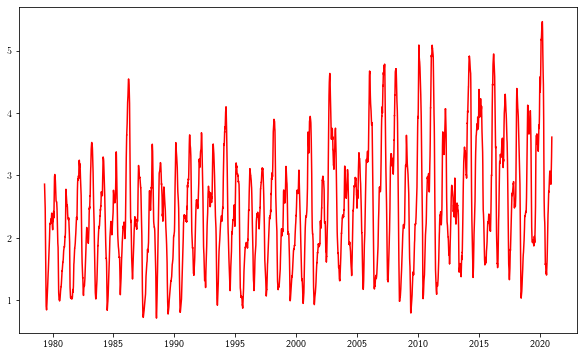

In [108]:
plt.rcParams.update({'figure.figsize': (10,6)})
#plt.plot(dates[:-1:3],ff['eigenvalue'][639::640],'.', alpha=.5)
data = pd.DataFrame()
data['eigenvalues'] =ff['eigenvalue'][639::640]
data['time'] = dates[:-1:3]
data.index = dates[:-1:3]
N=1000
data_ma = np.convolve(data['eigenvalues'].values, np.ones(N)/N, mode='full')
dates_ma = dates[:-1:3]
plt.plot(dates_ma[N:-1],data_ma[N:-N],'r', alpha=1)

In [107]:
data_ma[N:-N].shape


(122487,)

In [82]:
ff['eigenvalue'][0:640].max()
#ff['dates'] =dates[:-1:3]
data = pd.DataFrame()
data['eigenvalues'] =ff['eigenvalue'][639::640]
data['time'] = dates[:-1:3]
data.index = dates[:-1:3]

In [93]:
#plt.plot(dates[:-1:3],ff['eigenvalue'][639::640])
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
#result_mul = seasonal_decompose(data['eigenvalues'], model='additive', extrapolate_trend='freq')
#plt.rcParams.update({'figure.figsize': (10,10)})
#result_mul.plot()
#plt.show()

In [117]:
30*8


240

In [53]:
level="900"
file = "All_eigenvals_hourly_original_all_lambdas_all_years_loglog_L_060_"+level+".csv"
ff  = pd.read_csv(file, index_col=False)

In [54]:
ff.shape

(73697280, 2)

In [7]:
42*365*8*640


78489600

## Presure vs Height 

In [20]:
data = pd.read_csv('pressure_vs_height_n.txt', '\t', header=0)

In [21]:
data.columns = ['n','a','b','ph [hPa]','pf [hPa]','Geopotential Altitude [m]','Geometric Altitude [m]','Temperature [K]','Density [kg/m3]']

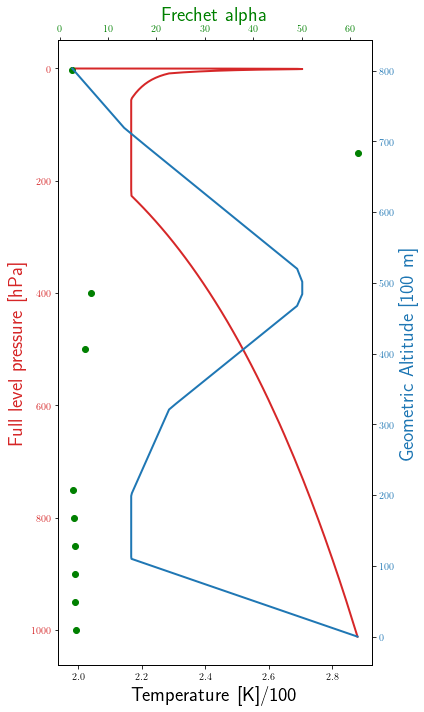

In [22]:
import seaborn as sns
alpha= pd.DataFrame()
alpha['Full level pressure [hPa]']= [2,5,10,30,70,150,200,300,400,500,600,700,750,800,850,900,950,1000]
alpha['alpha']= [2.6363,'nan','nan','nan','nan',61.569,'nan','nan',6.55,5.3228,'nan','nan',2.8342,3.0444,3.2102,3.2206,3.1261,3.4289]

plt.rcParams.update({'figure.figsize': (6,10)})
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Temperature [K]/100',fontsize=20)
ax1.set_ylabel('Full level pressure [hPa]', color=color,fontsize=20)
ax1.plot(data['Temperature [K]']/100,data['pf [hPa]'],'-', color=color,lw=2)

ax3 = ax1.twiny()
ax3.plot(alpha['alpha'],alpha['Full level pressure [hPa]'],'o', color='g')
ax3.tick_params(axis='x', labelcolor='g')
ax3.set_xlabel('Frechet alpha', color='g',fontsize=20) 

ax1.tick_params(axis='y', labelcolor=color)
plt.gca().invert_yaxis()
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Geometric Altitude [100 m]', color=color,fontsize=20)  # we already handled the x-label with ax1
ax2.plot(data['Temperature [K]']/100,data['Geometric Altitude [m]']/100,'-', color=color,lw=2)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.savefig('pressure_altitude_alpah.png', bbox_inches = 'tight',  pad_inches = 0,dpi=300)
#plt.plot(data['Temperature [K]']/100,data['pf [hPa]'],'--')
#plt.plot(data['Temperature [K]']/100,data['Geometric Altitude [m]']/100,'--')
#plt.plot(data['Temperature [K]'],data['Geopotential Altitude [m]'],'--')


In [23]:
data.columns

Index(['n', 'a', 'b', 'ph [hPa]', 'pf [hPa]', 'Geopotential Altitude [m]',
       'Geometric Altitude [m]', 'Temperature [K]', 'Density [kg/m3]'],
      dtype='object')

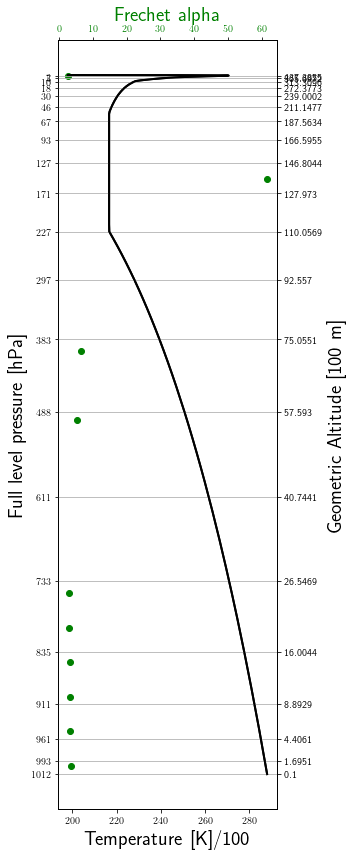

In [24]:
import seaborn as sns
alpha= pd.DataFrame()
alpha['Full level pressure [hPa]']= [2,5,10,30,70,150,200,300,400,500,600,700,750,800,850,900,950,1000]
alpha['alpha']= [2.6363,'nan','nan','nan','nan',61.569,'nan','nan',6.55,5.3228,'nan','nan',2.8342,3.0444,3.2102,3.2206,3.1261,3.4289]

plt.rcParams.update({'figure.figsize': (5,12)})
fig, ax1 = plt.subplots()
color = 'black'
ax1.set_xlabel('Temperature [K]/100',fontsize=20)
ax1.set_ylabel('Full level pressure [hPa]', color=color,fontsize=20)
ax1.plot(data['Temperature [K]'],data['pf [hPa]'],'-', color=color,lw=2)
ax1.set_yticks(data['pf [hPa]'][16::6])

ax3 = ax1.twiny()
ax3.plot(alpha['alpha'],alpha['Full level pressure [hPa]'],'o', color='g')
ax3.tick_params(axis='x', labelcolor='g')
ax3.set_xlabel('Frechet alpha', color='g',fontsize=20) 
#
ax1.tick_params(axis='y', labelcolor=color)
plt.gca().invert_yaxis()
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
#
color = 'black'
ax2.set_ylabel('Geometric Altitude [100 m]', color=color,fontsize=20)  # we already handled the x-label with ax1
#ax2.plot(data['Density [kg/m3]'],data['Geometric Altitude [m]']/100,'-', color=color,lw=2)
ax2.tick_params(axis='y', labelcolor=color)
dd = data['Geometric Altitude [m]']/100
ax2.plot(data['Temperature [K]'],data['pf [hPa]'],'-', color=color,lw=2)
#ax2.set_yticks(data['pf [hPa]'][::10])
ax2.set_yticks(data['pf [hPa]'][16::6])
height = []
pr = data['pf [hPa]'][16::6]
dd = dd[16::6]
for i in range(len(dd)):
    height.append(str(dd.values[pr==pr.values[i]])[1:-1])

#ax2.set_yticks(height)
ax2.invert_yaxis()
fig.canvas.draw()

labels = [item.get_text() for item in ax2.get_yticklabels()]
labels = height
ax2.grid(axis='y')
ax2.set_yticklabels(labels)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
#
plt.savefig('pressure_altitude_alpah_temperature.png', bbox_inches = 'tight',  pad_inches = 0,dpi=300)
##plt.plot(data['Temperature [K]']/100,data['pf [hPa]'],'--')
##plt.plot(data['Temperature [K]']/100,data['Geometric Altitude [m]']/100,'--')
##plt.plot(data['Temperature [K]'],data['Geopotential Altitude [m]'],'--')
#

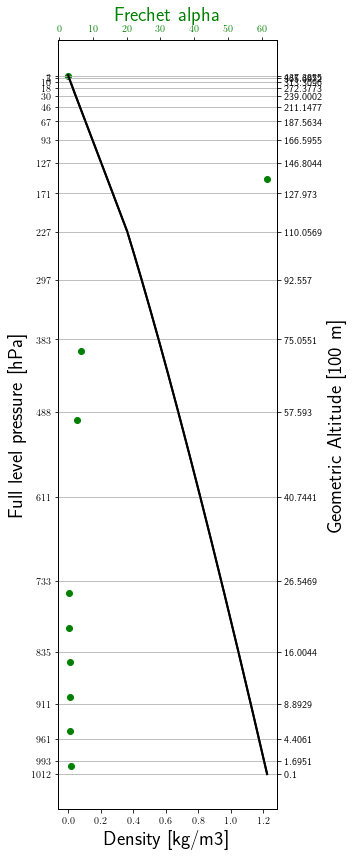

In [25]:
import seaborn as sns
alpha= pd.DataFrame()
alpha['Full level pressure [hPa]']= [2,5,10,30,70,150,200,300,400,500,600,700,750,800,850,900,950,1000]
alpha['alpha']= [2.6363,'nan','nan','nan','nan',61.569,'nan','nan',6.55,5.3228,'nan','nan',2.8342,3.0444,3.2102,3.2206,3.1261,3.4289]

plt.rcParams.update({'figure.figsize': (5,12)})
fig, ax1 = plt.subplots()
color = 'black'
ax1.set_xlabel('Density [kg/m3]',fontsize=20)
ax1.set_ylabel('Full level pressure [hPa]', color=color,fontsize=20)
ax1.plot(data['Density [kg/m3]'],data['pf [hPa]'],'-', color=color,lw=2)
ax1.set_yticks(data['pf [hPa]'][16::6])

ax3 = ax1.twiny()
ax3.plot(alpha['alpha'],alpha['Full level pressure [hPa]'],'o', color='g')
ax3.tick_params(axis='x', labelcolor='g')
ax3.set_xlabel('Frechet alpha', color='g',fontsize=20) 
#
ax1.tick_params(axis='y', labelcolor=color)
plt.gca().invert_yaxis()
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
#
color = 'black'
ax2.set_ylabel('Geometric Altitude [100 m]', color=color,fontsize=20)  # we already handled the x-label with ax1
#ax2.plot(data['Density [kg/m3]'],data['Geometric Altitude [m]']/100,'-', color=color,lw=2)
ax2.tick_params(axis='y', labelcolor=color)
dd = data['Geometric Altitude [m]']/100
ax2.plot(data['Density [kg/m3]'],data['pf [hPa]'],'-', color=color,lw=2)
#ax2.set_yticks(data['pf [hPa]'][::10])
ax2.set_yticks(data['pf [hPa]'][16::6])
height = []
pr = data['pf [hPa]'][16::6]
dd = dd[16::6]
for i in range(len(dd)):
    height.append(str(dd.values[pr==pr.values[i]])[1:-1])

#ax2.set_yticks(height)
ax2.invert_yaxis()
fig.canvas.draw()

labels = [item.get_text() for item in ax2.get_yticklabels()]
labels = height
ax2.grid(axis='y')
ax2.set_yticklabels(labels)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
#
plt.savefig('pressure_altitude_alpah_density.png', bbox_inches = 'tight',  pad_inches = 0,dpi=300)
##plt.plot(data['Temperature [K]']/100,data['pf [hPa]'],'--')
##plt.plot(data['Temperature [K]']/100,data['Geometric Altitude [m]']/100,'--')
##plt.plot(data['Temperature [K]'],data['Geopotential Altitude [m]'],'--')
#

In [26]:
data.head()

,n,a,b,ph [hPa],pf [hPa],Geopotential Altitude [m],Geometric Altitude [m],Temperature [K],Density [kg/m3]
0,1,2.000365,0.0,0.0200,0.0100,79301.79,80301.65,198.05,0.000018
1,2,3.102241,0.0,0.0310,0.0255,73721.58,74584.91,209.21,0.000042
2,3,4.666084,0.0,0.0467,0.0388,71115.75,71918.79,214.42,0.000063
3,4,6.827977,0.0,0.0683,0.0575,68618.43,69365.77,221.32,0.000090
4,5,9.746966,0.0,0.0975,0.0829,66210.99,66906.53,228.06,0.000127


In [26]:
data['Geometric Altitude [m]'][data['pf [hPa]'] == 200]

Series([], Name: Geometric Altitude [m], dtype: float64)

### Plot the U-wind profiles 

In [3]:
data_u_wind_2019 = "/media/fallah/bijan/ABBAS/ERA5_monthly/adaptor.mars.internal-1617695656.3323193-26098-14-e74d31d8-c8cc-45b2-8bf6-d2eb059ba114.nc"
# read the netcdf 
def read_stats(file,var):
    '''
    function to red  the netcdf of the ensemble: 
    file: the netcdf file name
    var : the variable you want to read
    '''
    nc = NetCDFFile(file)
    var = nc.variables[var][:].squeeze()
    nc.close()
    return var



In [55]:
u_wind = read_stats(data_u_wind_2019, var="u")
levels = read_stats(data_u_wind_2019, var="level")
lat    = read_stats(data_u_wind_2019, var="latitude")

In [56]:
u_wind_zonal = np.mean(u_wind,axis=3)
u_wind_fldmean = np.mean(u_wind_zonal,axis=2)

In [19]:
u_wind_zonal.shape


(12, 37, 721)

In [20]:
u_wind_fldmean.shape

(12, 37)

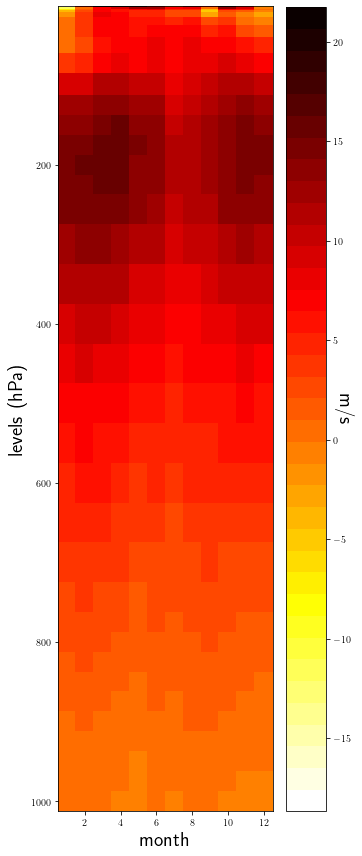

In [47]:
plt.rcParams.update({'figure.figsize': (5,12)})
fig, ax = plt.subplots()
cmap = plt.cm.get_cmap("hot_r", 37)
mon,lev = np.meshgrid(levels,range(1,13))
mon.shape
#xpt,ypt = map(lon,lat)
cs = plt.pcolormesh(lev,mon,u_wind_fldmean,cmap=cmap,shading='nearest')
cbar = plt.colorbar()
cbar.ax.set_ylabel('m/s', rotation=270, fontsize=20)
plt.xlabel('month', fontsize=20)
plt.ylabel('levels (hPa)', fontsize=20)
ax.invert_yaxis()
fig.tight_layout()  # otherwise the right y-label is slightly clipped
#
plt.savefig('u_component_of_wind_2019_averaged_over_lon_lat.png', 
            bbox_inches = 'tight',  pad_inches = 0,dpi=300)

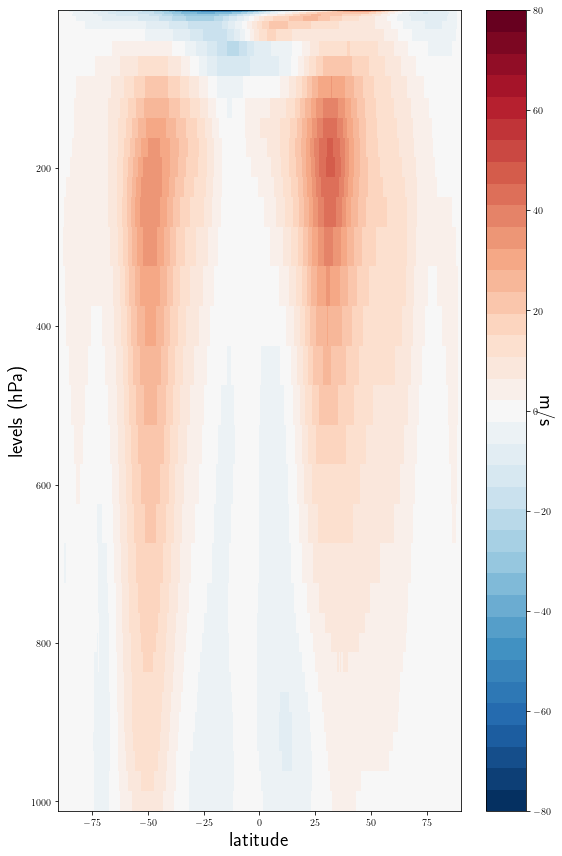

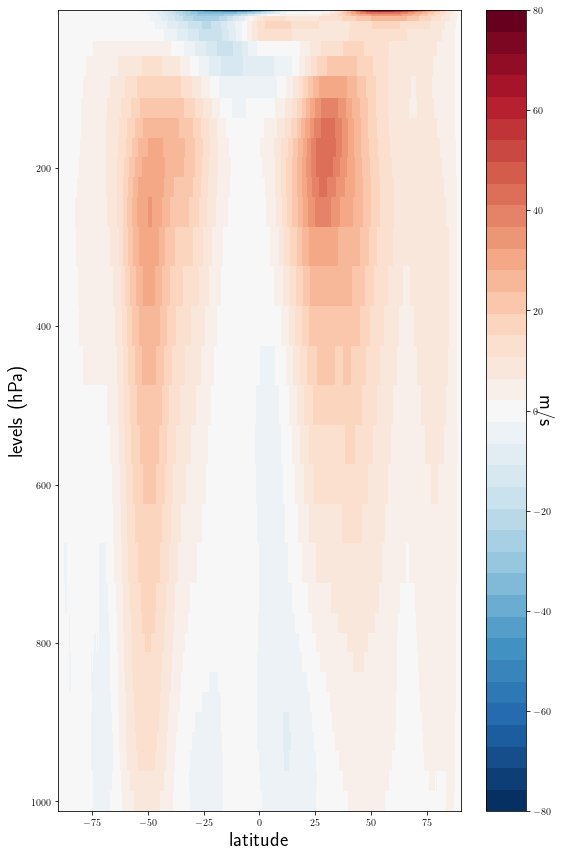

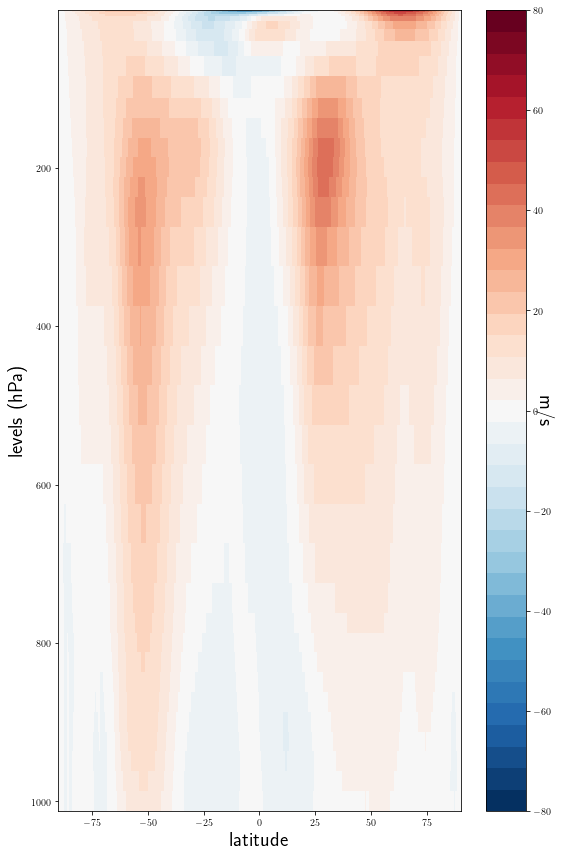

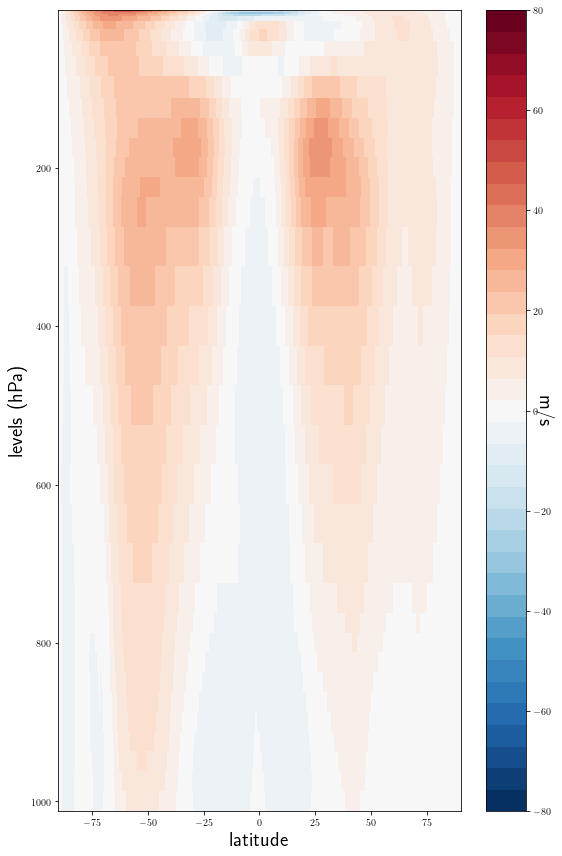

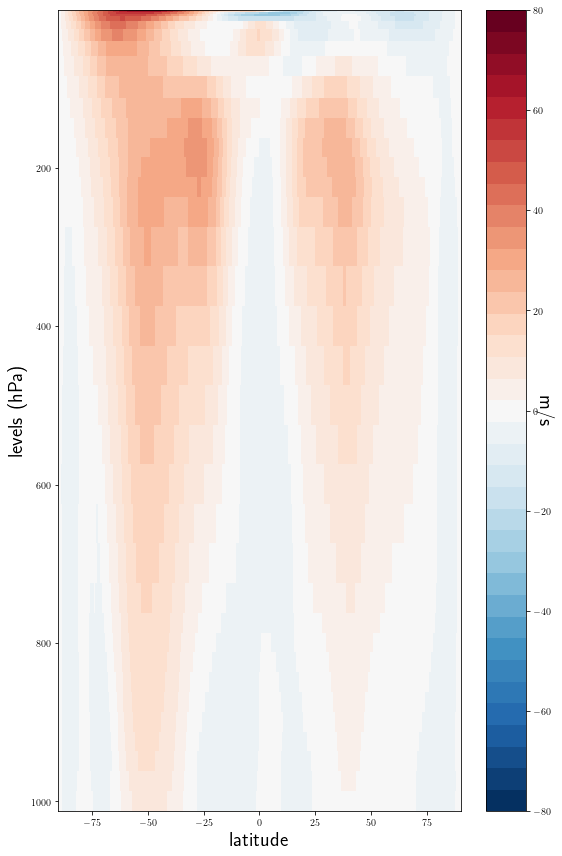

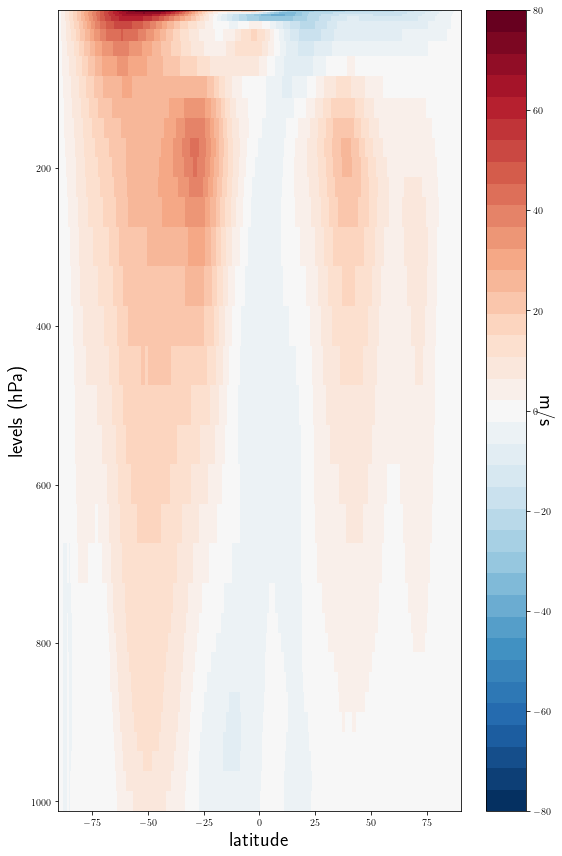

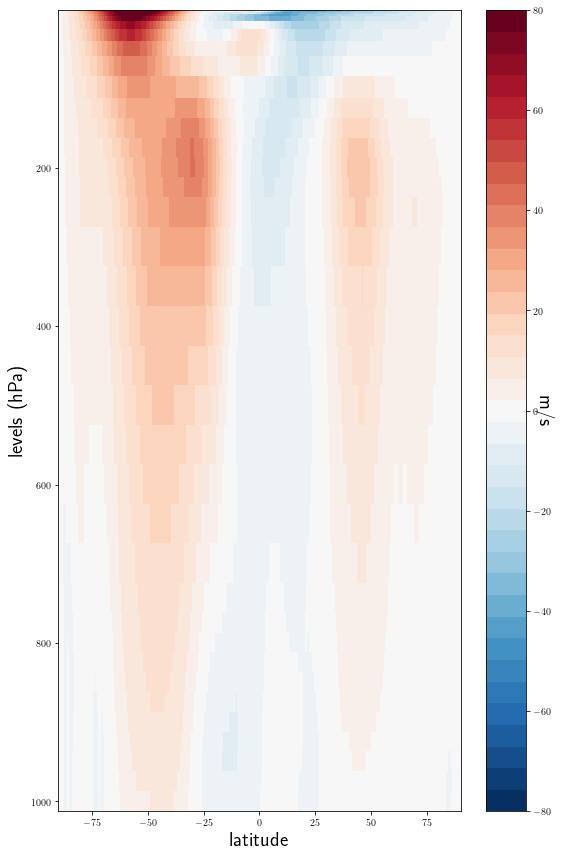

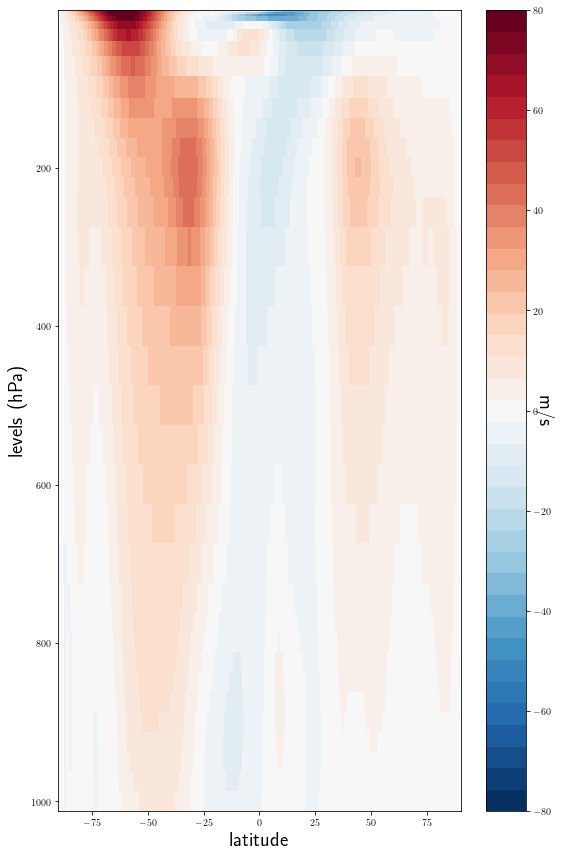

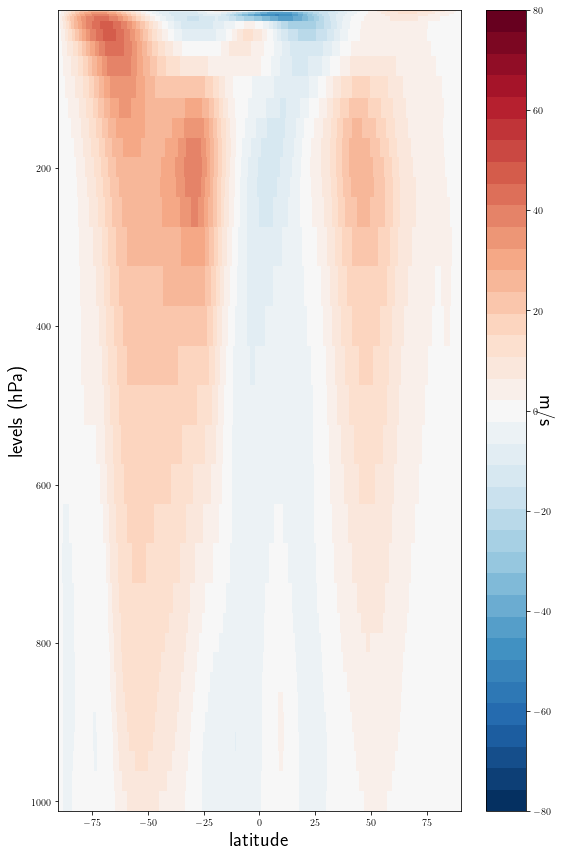

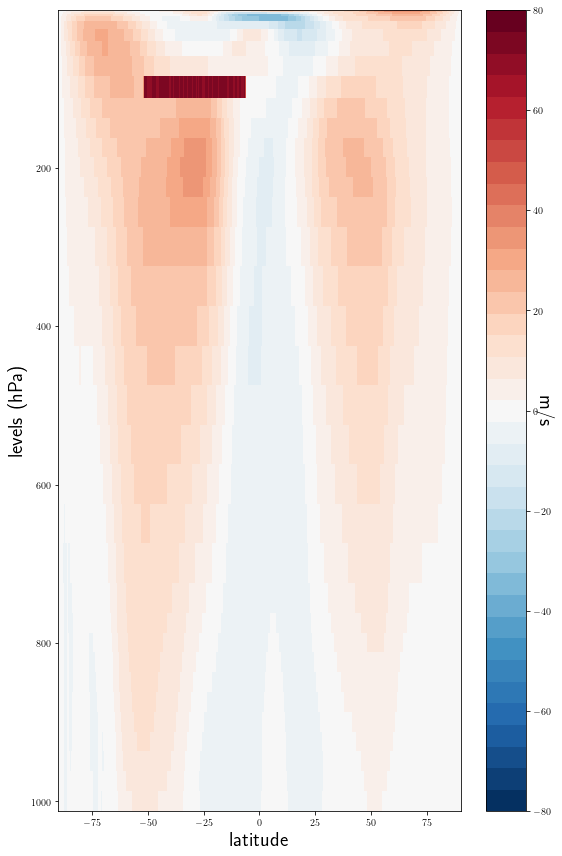

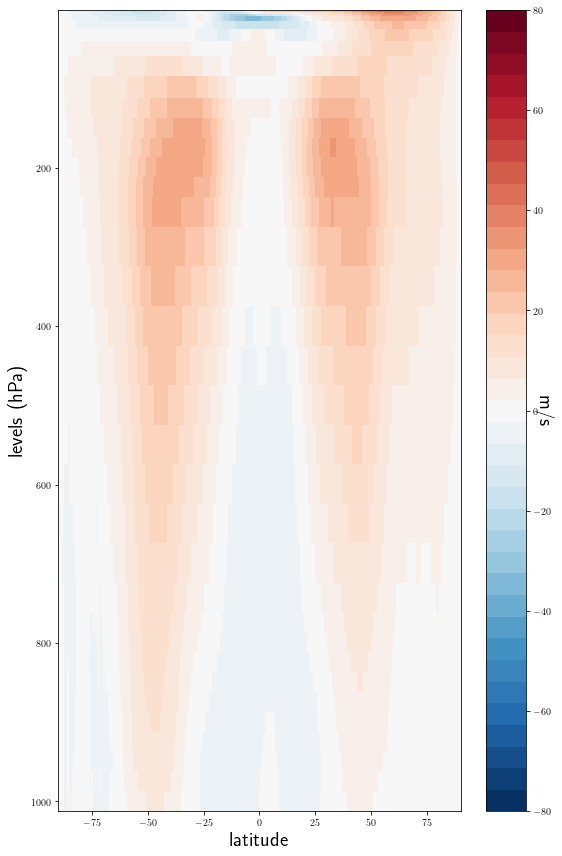

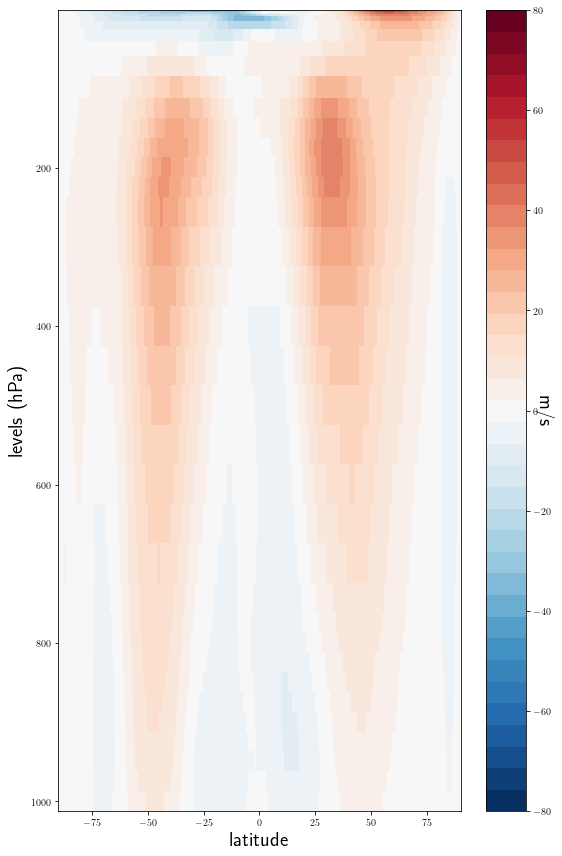

In [74]:
plt.rcParams.update({'figure.figsize': (8,12)})
for i in range(12):
    
    fig, ax = plt.subplots()
    cmap = plt.cm.get_cmap("RdBu_r", 37)
    lats,lev = np.meshgrid(lat,levels)
    cs = plt.pcolormesh(lats,lev,u_wind_zonal[i,:,:],vmin=-80, vmax=80,cmap=cmap,shading='nearest')
    cbar = plt.colorbar()
    cbar.ax.set_ylabel('m/s', rotation=270, fontsize=20)
    plt.xlabel('latitude', fontsize=20)
    plt.ylabel('levels (hPa)', fontsize=20)
    ax.invert_yaxis()
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    #
    plt.savefig('u_component_of_wind_2019_averaged_over_lon_month_'+str(i)+'.png', 
                bbox_inches = 'tight',  pad_inches = 0,dpi=300)

In [61]:
lats.shape

(37, 721)

### Plot the u component for all years 1979_2020

In [14]:
data_u_wind_2019 = "/media/fallah/bijan/ABBAS/ERA5_monthly/131_ERA5_ymonmean.nc"
u_wind = read_stats(data_u_wind_2019, var="u")
levels = read_stats(data_u_wind_2019, var="plev")
lat    = read_stats(data_u_wind_2019, var="lat")


In [15]:
u_wind[u_wind>1000] = np.float('nan')
u_wind[u_wind<-1000] = np.float('nan')
u_wind_zonal = np.nanmean(u_wind,axis=3)
u_wind_fldmean = np.nanmean(u_wind_zonal,axis=2)

<ipython-input-15-f8cf604b5987>:3: RuntimeWarning: Mean of empty slice
  u_wind_zonal = np.nanmean(u_wind,axis=3)


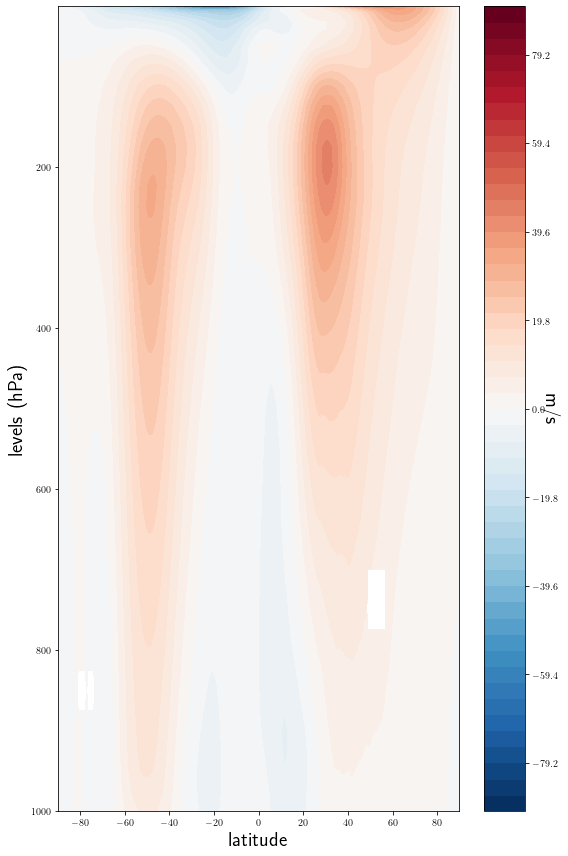

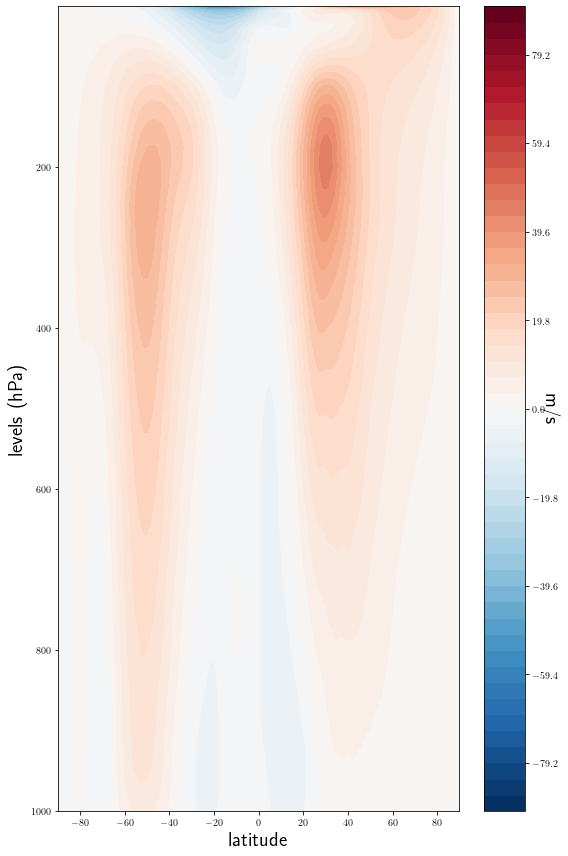

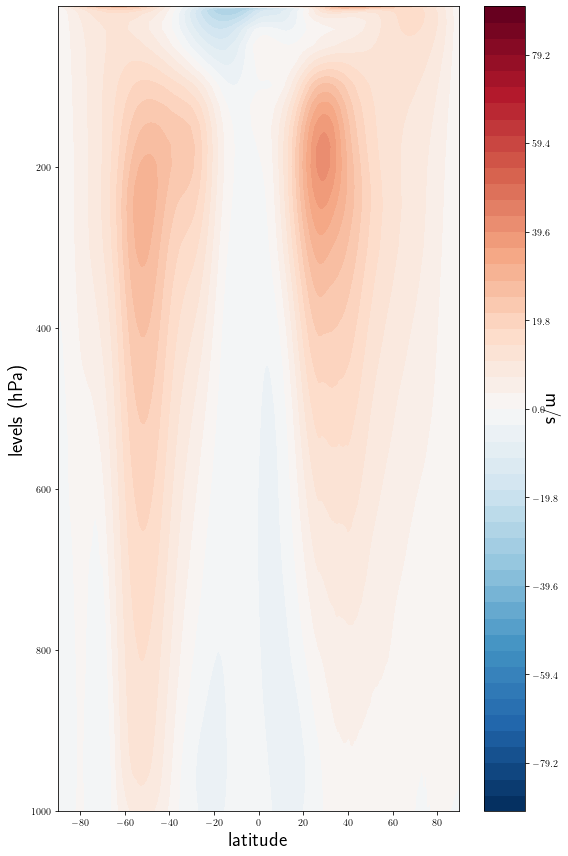

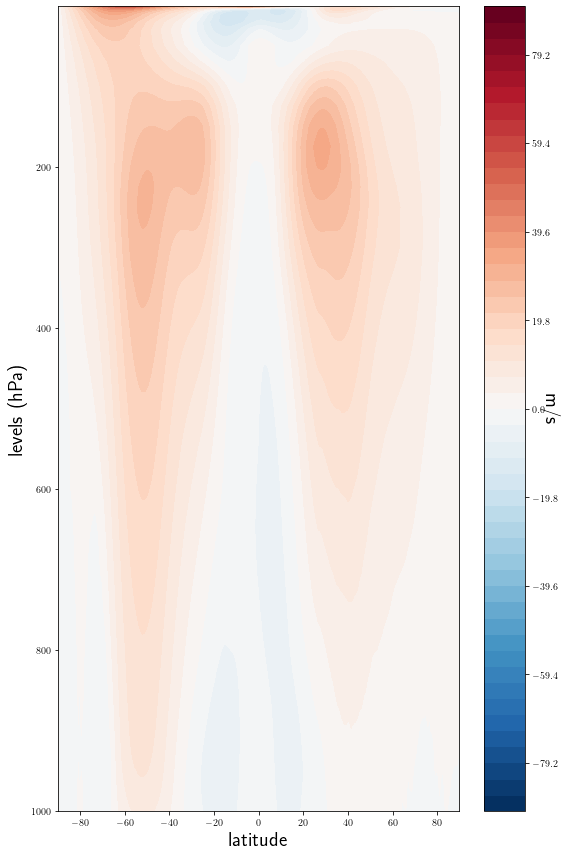

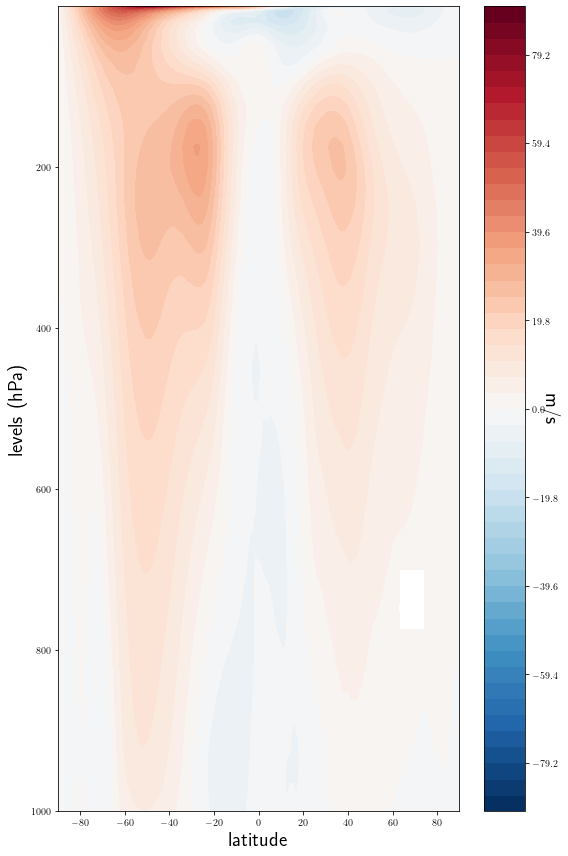

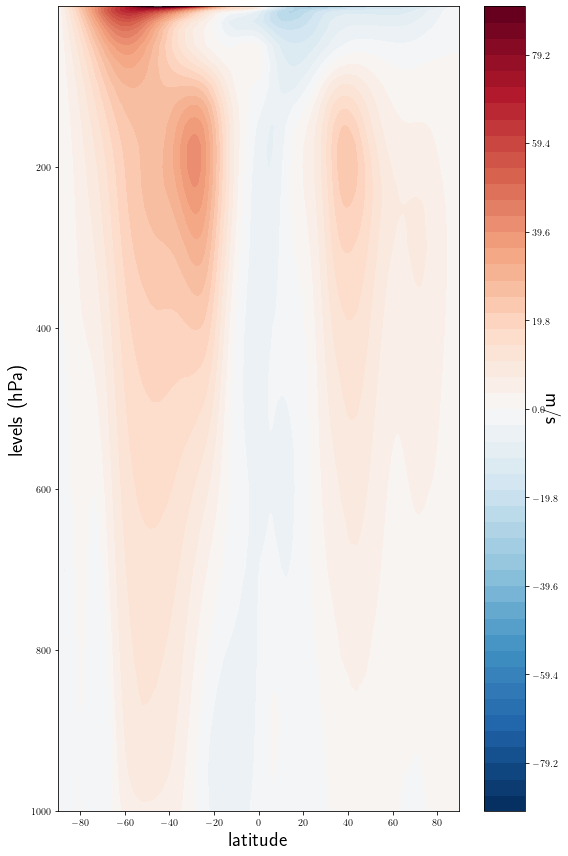

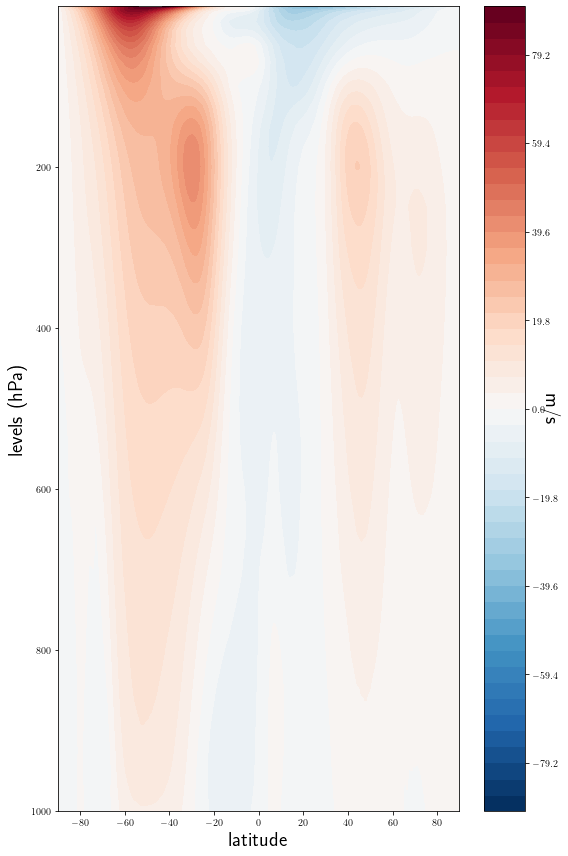

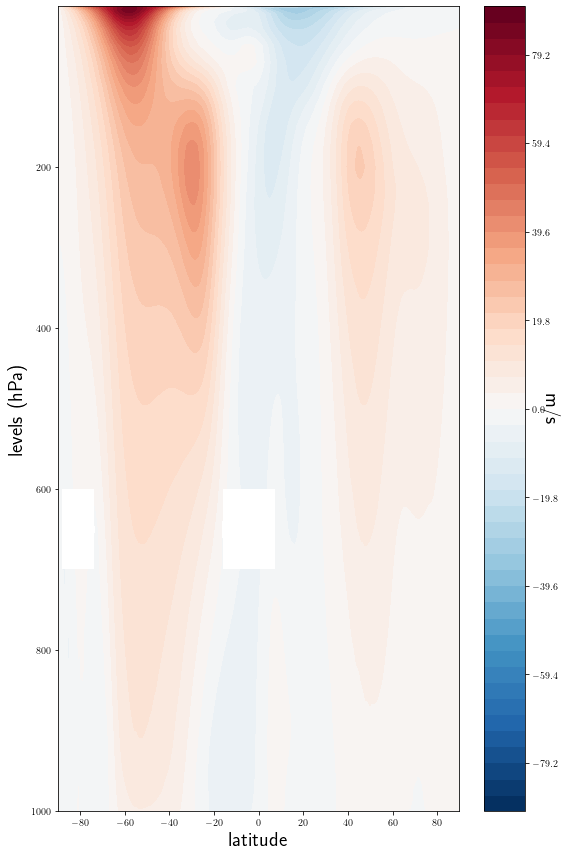

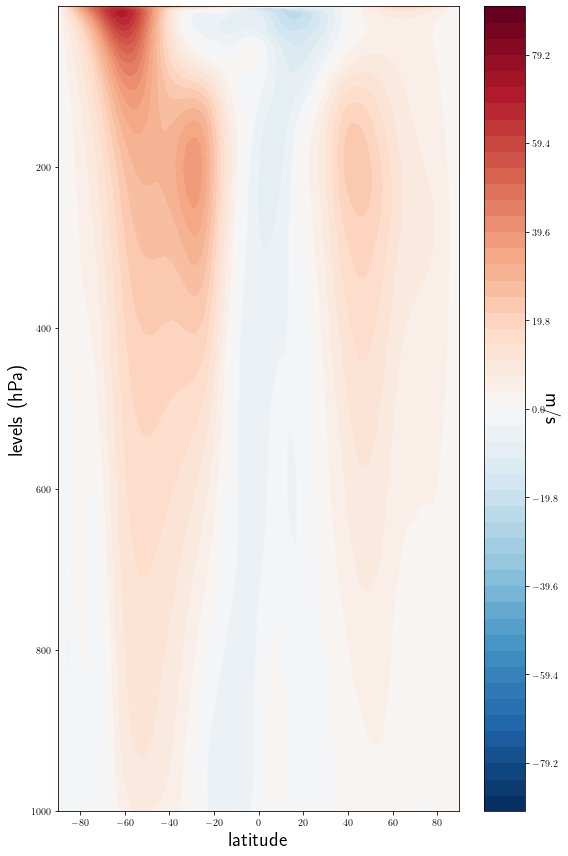

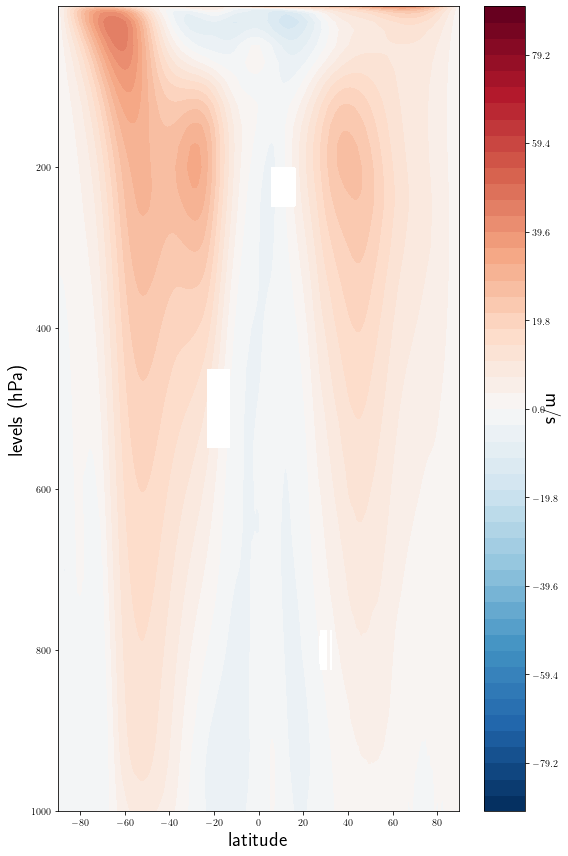

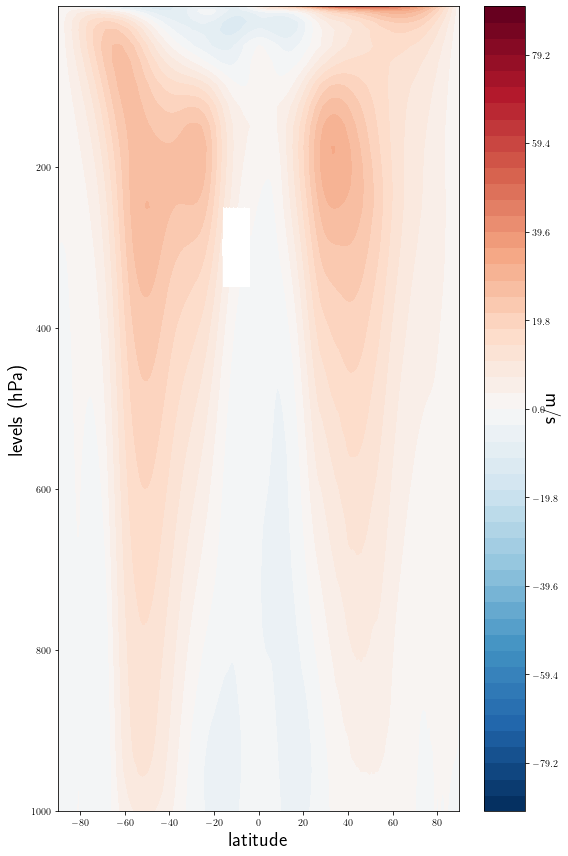

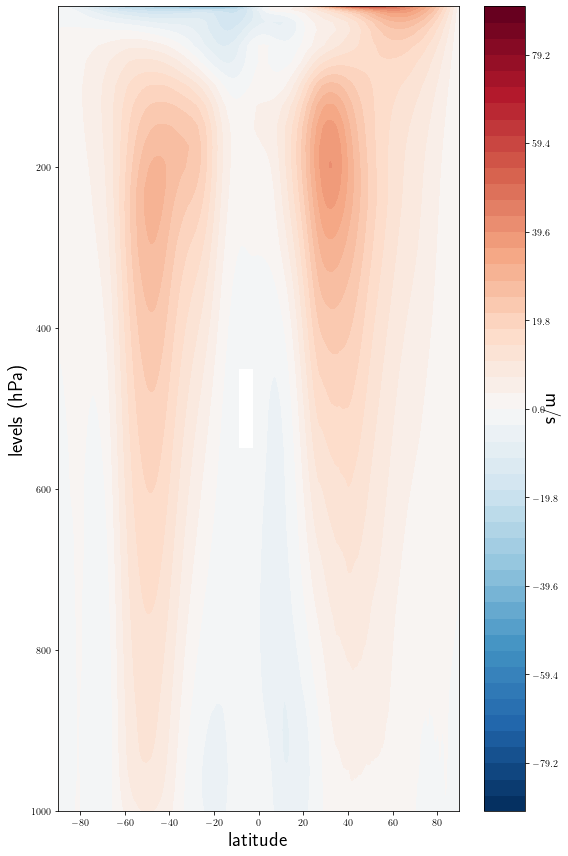

In [56]:
plt.rcParams.update({'figure.figsize': (8,12)})
for i in range(12):
    
    fig, ax = plt.subplots()
    cmap = plt.cm.get_cmap("RdBu_r", 50)
    lats,lev = np.meshgrid(lat,levels)
    #u_wind_zonal[u_wind_zonal>100000] = np.float('nan')
    #u_wind_zonal[u_wind_zonal<-100000] = np.float('nan')
    #cs = plt.pcolormesh(lats,lev/100,u_wind_zonal[i,:,:],vmin=-80, vmax=80,cmap=cmap,shading='flat')
    leve = 100

    level_boundaries = np.linspace(-90, 90, leve + 1)

    cs = plt.contourf(lats,lev/100,u_wind_zonal[i,:,:],level_boundaries ,cmap=cmap)
    
    cbar = plt.colorbar()
    cbar.ax.set_ylabel('m/s', rotation=270, fontsize=20)
    plt.xlabel('latitude', fontsize=20)
    plt.ylabel('levels (hPa)', fontsize=20)
    ax.invert_yaxis()
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    #
    plt.savefig('u_component_of_wind_1979_2020_averaged_over_lon_month_'+str(i)+'.png', 
                bbox_inches = 'tight',  pad_inches = 0,dpi=300)

<ipython-input-16-94f980ccc4b6>:14: UserWarning: The following kwargs were not used by contour: 'shading'
  cs = plt.contourf(lev,mon,u_wind_fldmean,level_boundaries,cmap=cmap,shading='auto')


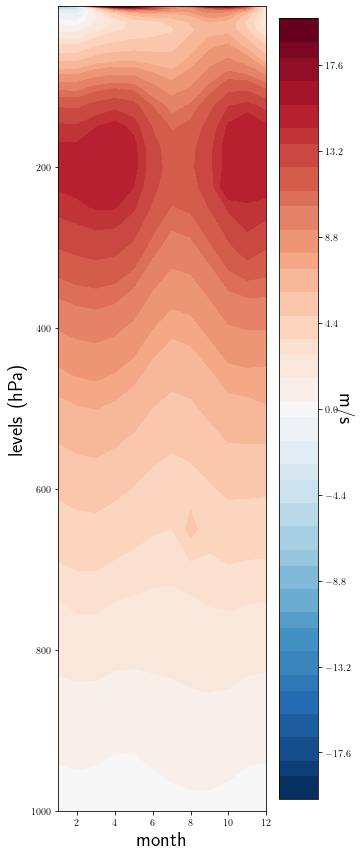

In [16]:
plt.rcParams.update({'figure.figsize': (5,12)})
fig, ax = plt.subplots()
cmap = plt.cm.get_cmap("RdBu_r", 37)
mon,lev = np.meshgrid(levels/100,range(1,13))
mon.shape
#xpt,ypt = map(lon,lat)
#cs = plt.pcolormesh(lev,mon,u_wind_fldmean,cmap=cmap, vmin=-20, vmax=20,shading='flat')
#u_wind_fldmean[u_wind_fldmean>1000] = np.float('nan')
#u_wind_fldmean[u_wind_fldmean<-1000] = np.float('nan')
leve = 100

level_boundaries = np.linspace(-20, 20, leve + 1)

cs = plt.contourf(lev,mon,u_wind_fldmean,level_boundaries,cmap=cmap,shading='auto')
cbar = plt.colorbar()
cbar.ax.set_ylabel('m/s', rotation=270, fontsize=20)
plt.xlabel('month', fontsize=20)
plt.ylabel('levels (hPa)', fontsize=20)
ax.invert_yaxis()
fig.tight_layout()  # otherwise the right y-label is slightly clipped
#
plt.savefig('u_component_of_wind_1979_2020_averaged_over_lon_lat.png', 
            bbox_inches = 'tight',  pad_inches = 0,dpi=300)

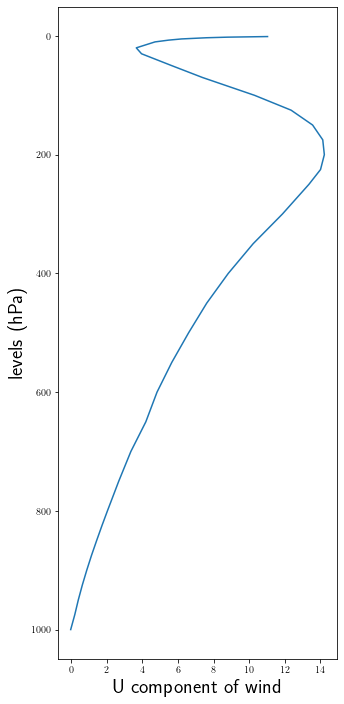

In [30]:
plt.rcParams.update({'figure.figsize': (5,12)})
fig, ax = plt.subplots()
cmap = plt.cm.get_cmap("RdBu_r", 37)
#mon,lev = np.meshgrid(levels/100,range(1,13))
#mon.shape
#xpt,ypt = map(lon,lat)
#cs = plt.pcolormesh(lev,mon,u_wind_fldmean,cmap=cmap, vmin=-20, vmax=20,shading='flat')
#u_wind_fldmean[u_wind_fldmean>1000] = np.float('nan')
#u_wind_fldmean[u_wind_fldmean<-1000] = np.float('nan')
#leve = 100

#level_boundaries = np.linspace(-20, 20, leve + 1)

cs = plt.plot(np.nanmean(u_wind_fldmean,axis=0),levels/100)
#cbar = plt.colorbar()
#cbar.ax.set_ylabel('m/s', rotation=270, fontsize=20)
plt.xlabel('U component of wind', fontsize=20)
plt.ylabel('levels (hPa)', fontsize=20)
ax.invert_yaxis()
#fig.tight_layout()  # otherwise the right y-label is slightly clipped





plt.savefig('u_component_of_wind_1979_2020_averaged_over_lon_lat.png', 
            bbox_inches = 'tight',  pad_inches = 0,dpi=300)

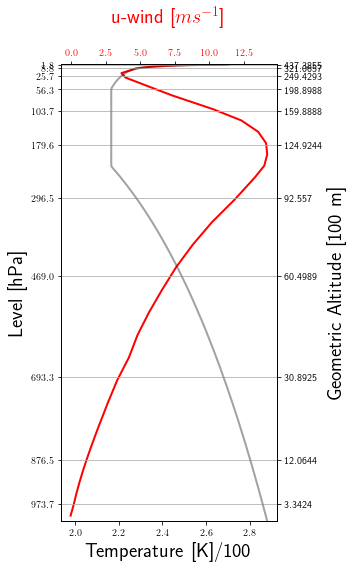

In [62]:
delta=11
import seaborn as sns
alpha= pd.DataFrame()
alpha['Full level pressure [hPa]']= levels/100
alpha['alpha']= np.nanmean(u_wind_fldmean,axis=0)

plt.rcParams.update({'figure.figsize': (5,8)})
fig, ax1 = plt.subplots()
color = 'black'
ax1.set_xlabel('Temperature [K]/100',fontsize=20)
ax1.set_ylabel('Level [hPa]', color=color,fontsize=20)
ax1.plot(data['Temperature [K]']/100,data['pf [hPa]'],'-', color=color,lw=2, alpha=.2)
ax1.set_yticks(data['pf [hPa]'][16::delta])
ax1.set_ylim([0,1012])
ax3 = ax1.twiny()
ax3.plot(alpha['alpha'],alpha['Full level pressure [hPa]'],'-', color='r',lw=2)
ax3.tick_params(axis='x', labelcolor='r')
ax3.set_xlabel('u-wind [$ms^{-1}$]\n', color='r',fontsize=20) 
#
ax1.tick_params(axis='y', labelcolor=color)
plt.gca().invert_yaxis()
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
#
color = 'black'
ax2.set_ylabel('Geometric Altitude [100 m]', color=color,fontsize=20)  # we already handled the x-label with ax1
#ax2.plot(data['Density [kg/m3]'],data['Geometric Altitude [m]']/100,'-', color=color,lw=2)
ax2.tick_params(axis='y', labelcolor=color)
dd = data['Geometric Altitude [m]']/100
ax2.plot(data['Temperature [K]']/100,data['pf [hPa]'],'-', color=color,lw=2, alpha=.2)
#ax2.set_yticks(data['pf [hPa]'][::10])
ax2.set_yticks(data['pf [hPa]'][16::delta])
height = []
pr = data['pf [hPa]'][16::delta]
dd = dd[16::delta]
for i in range(len(dd)):
    height.append(str(dd.values[pr==pr.values[i]])[1:-1])

#ax2.set_yticks(height)
ax2.invert_yaxis()
fig.canvas.draw()

labels = [item.get_text() for item in ax2.get_yticklabels()]
labels = height
ax2.grid(axis='y')
ax2.set_yticklabels(labels)
ax2.set_ylim([1012,0])


fig.tight_layout()  # otherwise the right y-label is slightly clipped
#
plt.savefig('pressure_altitude_u_wind_temperature.png', bbox_inches = 'tight', 
            pad_inches = 0,dpi=300)
##plt.plot(data['Temperature [K]']/100,data['pf [hPa]'],'--')
##plt.plot(data['Temperature [K]']/100,data['Geometric Altitude [m]']/100,'--')
##plt.plot(data['Temperature [K]'],data['Geopotential Altitude [m]'],'--')
#

### Hovmüller plots u component of the wind 

In [90]:
data_u_wind_2019 = "/media/fallah/bijan/ABBAS/ERA5_monthly/131_ERA5_fldmean_yearmean.nc"
u_wind = read_stats(data_u_wind_2019, var="u")
levels = read_stats(data_u_wind_2019, var="plev")
#lat    = read_stats(data_u_wind_2019, var="lat")
u_wind[u_wind>1000] = np.float('nan')
u_wind[u_wind<-1000] = np.float('nan')

<ipython-input-91-80dc0d03beda>:14: UserWarning: The following kwargs were not used by contour: 'shading'
  cs = plt.contourf(year,lev,u_wind,level_boundaries,cmap=cmap,shading='auto')


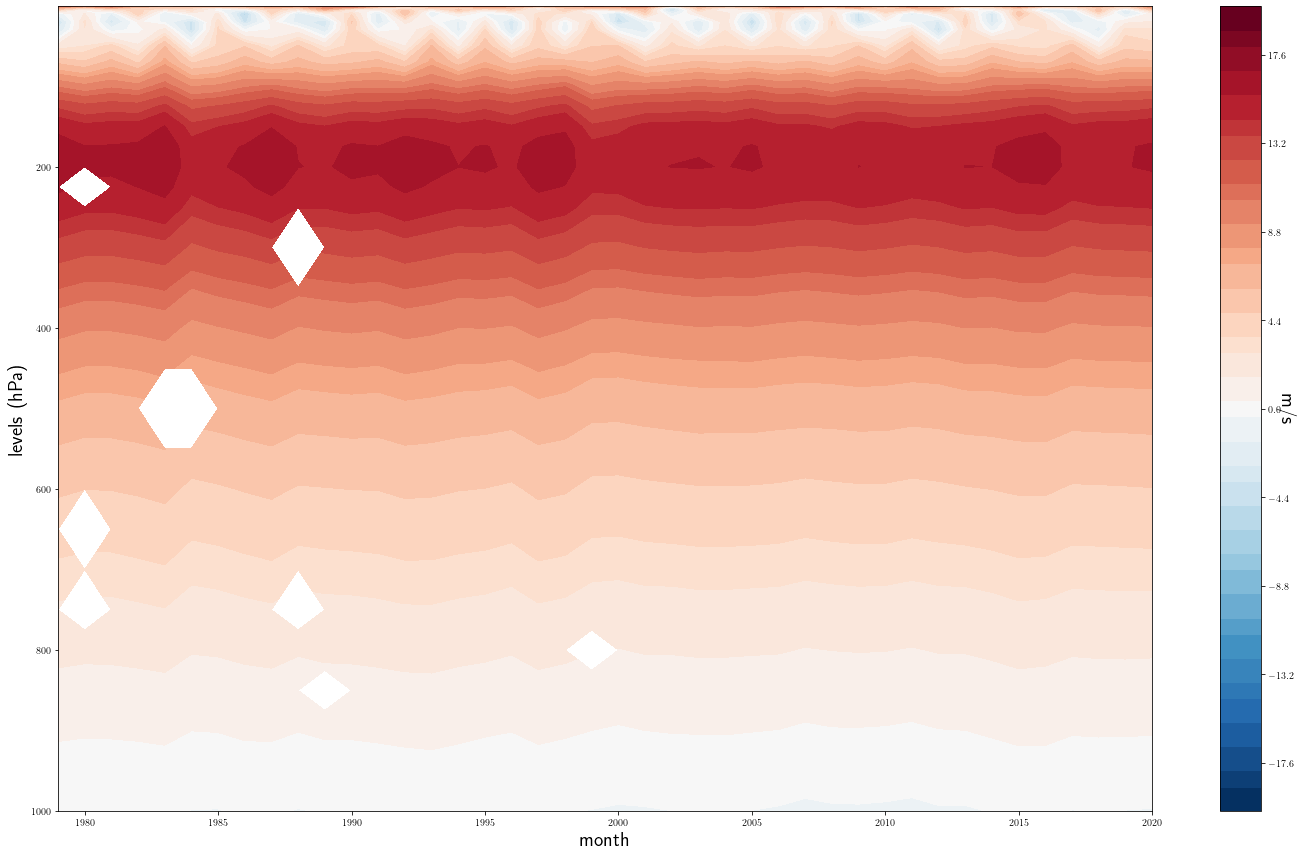

In [91]:
plt.rcParams.update({'figure.figsize': (20,12)})
fig, ax = plt.subplots()
cmap = plt.cm.get_cmap("RdBu_r", 37)
lev,year = np.meshgrid(levels/100,range(1979,2021))
#year.shape
#xpt,ypt = map(lon,lat)
#cs = plt.pcolormesh(lev,mon,u_wind_fldmean,cmap=cmap, vmin=-20, vmax=20,shading='flat')
#u_wind_fldmean[u_wind_fldmean>1000] = np.float('nan')
#u_wind_fldmean[u_wind_fldmean<-1000] = np.float('nan')
leve = 100

level_boundaries = np.linspace(-20, 20, leve + 1)

cs = plt.contourf(year,lev,u_wind,level_boundaries,cmap=cmap,shading='auto')
cbar = plt.colorbar()
cbar.ax.set_ylabel('m/s', rotation=270, fontsize=20)
plt.xlabel('month', fontsize=20)
plt.ylabel('levels (hPa)', fontsize=20)
ax.invert_yaxis()
fig.tight_layout()  # otherwise the right y-label is slightly clipped
#
plt.savefig('u_component_of_wind_1979_2020_averaged_over_lon_lat.png', 
            bbox_inches = 'tight',  pad_inches = 0,dpi=300)

In [248]:
# interpolate the holes (nans): 

from scipy.interpolate import griddata
xx = []
yy = []
uu = []
yyy = year.reshape(-1)
ll = lev.reshape(-1)
# make anomalies : 
u_wind_anomal = np.zeros(u_wind.shape)
for i in range(u_wind_anomal.shape[0]):
    u_wind_anomal[i,:] = u_wind[i,:] - np.nanmean(u_wind,axis=0)

#uuu = u_wind.reshape(-1)
uuu = u_wind_anomal.reshape(-1)

for i in range(uuu.shape[0]):
    xx.append(yyy[i])
    yy.append(ll[i])
    uu.append(uuu[i])

uu = np.array(uu)
xx = np.array(xx)
yy = np.array(yy)

In [249]:

Ti = griddata((xx[~np.isnan(uu)], yy[~np.isnan(uu)]), uu[~np.isnan(uu)], (year, lev), method='linear')


<ipython-input-264-e59fbe70de0b>:13: UserWarning: The following kwargs were not used by contour: 'shading'
  cs = plt.contourf(year[:,:],lev[:,:],Ti[:,:],level_boundaries,cmap=cmap,shading='auto')


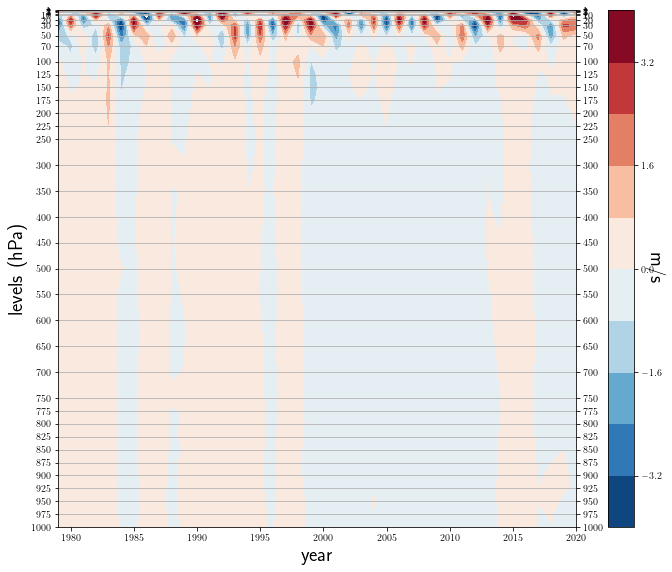

In [264]:
plt.rcParams.update({'figure.figsize': (10,8)})
fig, ax = plt.subplots()
cmap = plt.cm.get_cmap("RdBu_r", 50)
lev,year = np.meshgrid(levels/100,range(1979,2021))
#year.shape
#xpt,ypt = map(lon,lat)
#cs = plt.pcolormesh(lev,mon,u_wind_fldmean,cmap=cmap, vmin=-20, vmax=20,shading='flat')
#u_wind_fldmean[u_wind_fldmean>1000] = np.float('nan')
#u_wind_fldmean[u_wind_fldmean<-1000] = np.float('nan')
leve = 10

level_boundaries = np.linspace(-4,4, leve + 1)
cs = plt.contourf(year[:,:],lev[:,:],Ti[:,:],level_boundaries,cmap=cmap,shading='auto')

#cs = plt.contourf(year[:,:-27],lev[:,:-27],Ti[:,:-27],level_boundaries,cmap=cmap,shading='auto')
#cs = plt.pcolormesh(year,lev,Ti,cmap=cmap, vmin=-18,vmax=18)
#cs = plt.contourf(year[:,20:],lev[:,20:],Ti[:,20:],level_boundaries,cmap=cmap,shading='auto')
ax.tick_params(labeltop=False, labelright=True)
cbar = plt.colorbar()
cbar.ax.set_ylabel('m/s', rotation=270, fontsize=20)
plt.xlabel('year', fontsize=20)
plt.ylabel('levels (hPa)', fontsize=20)
ax.invert_yaxis()
plt.tick_params(labeltop=False, labelright=True)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
ax.set_yticks(levels/100)
ax.yaxis.set_ticks_position('both')


ax.grid(axis='y')
#
plt.savefig('u_component_of_wind_1979_2020_averaged_over_lon_lat_without_nans_anomaly.png', 
            bbox_inches = 'tight',  pad_inches = 0,dpi=300)

In [265]:
uu[np.isnan(np.array(uu)).astype(int)]

array([3.3395842, 3.3395842, 3.3395842, ..., 3.3395842, 3.3395842,
       3.3395842])

In [254]:
np.nanmax(uu)

5.208169710783419

In [145]:
uu[~np.isnan(uu)]

array([12.4278513 ,  7.96349898,  6.66904597, ..., -0.03553055,
       -0.2263073 , -0.42901886])